In [1]:
from astropy.table import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from astropy.table import hstack
import os
import seaborn as sns
from scipy.stats import binned_statistic
import matplotlib
import matplotlib.backends.backend_pdf
from scipy.stats import chi2, binned_statistic
from cosmic_calc import * 
from scipy.optimize import curve_fit
from bisect import bisect

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=18), plt.rc('ytick', labelsize=18)
plt.rcParams['savefig.dpi'] = 300
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

In [2]:
from scipy.optimize import curve_fit
from statsmodels.stats.weightstats import DescrStatsW

def power(x,a,b):
    return a*x**b

def sigmoid(x,a,b):
    return 1/(1+np.exp(-(x+b)/a+1))


def poisson_interval(k, a=0.3174): 
    lows = chi2.ppf(a/2, 2*k)/2
    highs = chi2.ppf(1-a/2, 2*k+2)/2 
    
    lows=np.array(lows)
    highs=np.array(highs)
    
    lows[np.isnan(lows)]=0
    return lows, highs

In [3]:
dev_path = '/Users/lejay/research/lephare_dev/my_code/'
output_dir = dev_path+'output_cats/'
graham_output_dir = dev_path + 'graham_output_cats/'

#### write sf/q info and load catalog

In [4]:
def gv_boundary_2(color1, ic_1, ic_2, slope):
    nuv_1 = ic_1
    nuv_2 = slope*color1 + ic_2
    return np.maximum(nuv_1, nuv_2)

In [82]:
diagram_type = 'NUVrK'
phot_config = 'nonir'
phot_type=2 # 0=optical 1=w/nir 2=w/irac 3=full 
best_boxes_nuvrk = np.load('best_select_box_onemassbin_lepharecheck_'+diagram_type+'_.npy')
    
for cat_name in ['COSMOS_deep','DEEP_deep','ELAIS_deep']:
    sfq_nuvrk = []
    cat_output_no_nir_mass_name = graham_output_dir+cat_name+'_cat_out_nomaglimit_'+phot_config+'_il_nz_prior_formass.fits'
    cat = Table.read(cat_output_no_nir_mass_name)
    for i in tqdm(range(len(cat))):
        gal = cat[i]
        if abs(gal['MAG_ABS_r']) < 99. and abs(gal['MAG_ABS_Ks'])< 99. and gal['MAG_ABS_NUV']< 99. and abs(gal['MAG_ABS_r'])< 99.:
            rk = gal['MAG_ABS_r'] - gal['MAG_ABS_Ks']
            nuvr = gal['MAG_ABS_NUV'] - gal['MAG_ABS_r']
            if gal['Z_ML']>0 and gal['Z_ML']<1.5:
                delta_gv_nuvrk = nuvr - gv_boundary_2(rk,best_boxes_nuvrk[phot_type][0],best_boxes_nuvrk[phot_type][1],best_boxes_nuvrk[phot_type][2])
                if delta_gv_nuvrk<0:
                    sfq_nuvrk.append(1.)
                else:
                    sfq_nuvrk.append(0.)
            else:
                sfq_nuvrk.append(-99.)
        else:
            sfq_nuvrk.append(99.)
        
    sfq_col_nuvrk = Column(name='sfq_nuvrk_myrun',data=sfq_nuvrk)  # 1=sf, 0=q
    if 'sfq_nuvrk_myrun' in cat.keys():
        cat.remove_column('sfq_nuvrk_myrun')
    cat.add_column(sfq_col_nuvrk)
    cat.write(cat_output_no_nir_mass_name.replace('.fits','_sfq_added.fits'),overwrite=True)
    

100%|██████████| 1155513/1155513 [07:21<00:00, 2616.15it/s]


In [16]:
cat_output_no_nir_mass_name = graham_output_dir+'cat_out_300k_nonir_il_formass.fits'
cat = Table.read(cat_output_no_nir_mass_name.replace('.fits','_sfq_added.fits'))
arr,ind = np.unique(cat['STRING_INPUT'],return_index=True)
cat = cat[ind]

#### completeness esitmation

In [5]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

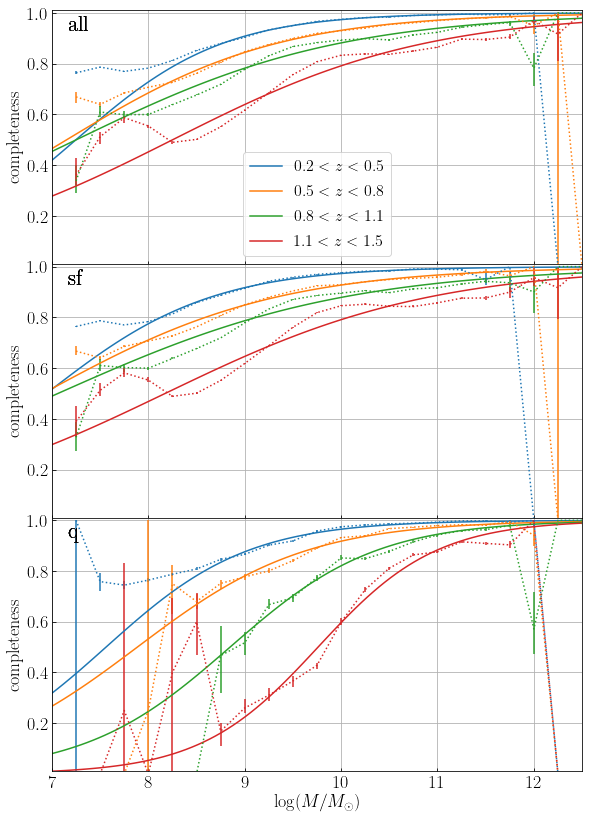

In [6]:
bin_edges = np.linspace(7, 13, num=25)
bin_centers = np.diff(bin_edges) + bin_edges[:-1]
comp_sigmoid_params = Table(names=['z','sfq','a','b'],dtype=['f8','a4','f8','f8'])
inside_j=True

zmins = [0.2,0.5,0.8,1.1]
zmaxs = [0.5,0.8,1.1,1.5]
# zmins = [0.3,0.5,0.7,0.9]
# zmaxs = [0.5,0.7,0.9,1.1]
fig, axs = plt.subplots(3, 1, figsize=(9.5,14),sharex=True, sharey=True)
for i,sfq in enumerate(['all','sf','q']):
    for k,z in enumerate(zmins):
        
        filename = 'completeness_curve_mag/curves/comp_bootstrap_nomaglimit_mass_sfq_nuvrk_myrun_'+sfq+'_'+str(zmins[k])+'_'+str(zmaxs[k])+'.txt'
        curves_mass = np.genfromtxt(filename)
        comp_all = np.median(curves_mass, axis=0)
        comp_all_l = np.percentile(curves_mass,16, axis=0)    
        comp_all_h = np.percentile(curves_mass,84, axis=0)
        if sfq == 'q':
            for j in range(len(comp_all)):
                if j<len(comp_all)/2 and np.isnan(comp_all[j]):
                    comp_all[j]=0
                elif j>len(comp_all)/2 and np.isnan(comp_all[j]):
                    comp_all[j]=1
        else:
            comp_all[np.isnan(comp_all)]=1
        
        # plot data
        axs[i].errorbar(bin_centers,comp_all,yerr=[comp_all-comp_all_l,comp_all_h-comp_all],fmt=colors[k],linestyle=':')
        
        # fitting (modified) sigmoid function to the curves
        popt, pcov = curve_fit(sigmoid, bin_centers[6:-5], comp_all[6:-5],maxfev = 1000)   
        comp_sigmoid_params.add_row([round(z,1),sfq,popt[0],popt[1]])
    
        # plot the sigmoid fit
        x_plot = np.linspace(7,13,100)
        y_plot = sigmoid(x_plot,popt[0],popt[1])
        axs[i].plot(x_plot,y_plot,label=r'$'+str(zmins[k])+'<z<'+str(zmaxs[k])+'$')
    
        axs[i].annotate(sfq,xy=([0.03,0.92]),xycoords='axes fraction',fontsize=22)
        axs[i].set_ylabel('completeness',fontsize=18)
        axs[0].legend(fontsize=16)
        axs[i].set_xlim([7,12.5])
    axs[i].grid()
        
plt.ylim([0.01,1.01])
plt.xlabel(r'$\log(M/M_\odot)$',fontsize=18)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

comp_sigmoid_params.write('comp_sigmoid_params.fits',overwrite=True)

#### mass vs z
use overall catalog

(6.8, 12.6)

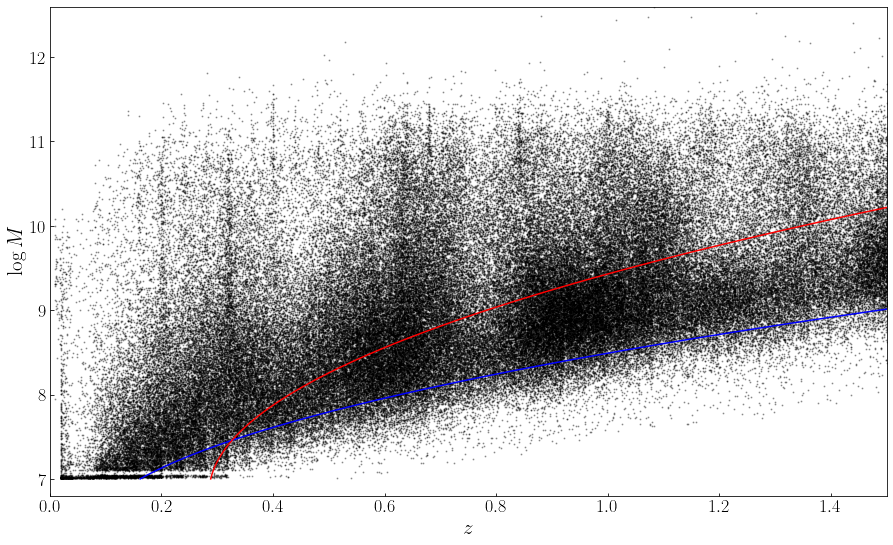

In [7]:
cat = Table.read('/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_300k_nonir_il_formass.fits')

# z_edges = np.linspace(0,1.6,17)
# m_mins = []
# for z_min in z_edges[:-1]:
#     cat_z= cat[cat['Z_ML']>z_min]
#     cat_z= cat_z[cat_z['Z_ML']<z_min+0.1]
    
#     mass_cut20 = np.percentile(cat_z['MASS_MED_massrun'],20)
#     cat_z_lowmass = cat_z[cat_z['MASS_MED_massrun']<mass_cut20]
#     m_lims = cat_z_lowmass['MASS_MED_massrun'] + 0.4*(cat_z_lowmass['i']-26)
#     m_min =  np.percentile(m_lims,95)
#     m_mins.append(m_min)

fig, axs = plt.subplots(1, 1, figsize = (15, 9),sharex=True, sharey=True)
im = plt.scatter(cat['Z_ML'],cat['MASS_MED_massrun'],s=1,c='k',alpha=0.3)
# plt.plot(z_edges[:-1]+0.05,m_mins,color='r')

# plt.scatter([0.4,0.6,0.8,1.0],[8.6,9.2,9.5,9.75],s=50,color='r')
# plt.scatter([0.4,0.6,0.8,1.0],[8.2,8.5,8.8,9.0],s=50,color='orange')

# fit a 2nd order polonomial (mass as independent variable)
# p = np.polyfit(m_mins,z_edges[:-1]+0.05,deg=2)
# mass_plot = np.linspace(7,12.5,1000)
# plt.plot(p[0]*mass_plot**2 + p[1]*mass_plot + p[2], mass_plot, color='b')

# fit for sf and q galaxies (70% completeness from v9 catalog)
xs = [0.4,0.6,0.8,1.0]
ys_sf = [7.6, 8, 8.2, 8.5]
ys_q = [7.9, 8.5, 9.1, 9.4]

# ploy-fit for mass limit
mass_plot = np.linspace(7,12.5,1000)
p_sf = np.polyfit(ys_sf,xs,deg=2) # ploy-fit for sf mass limit
p_q = np.polyfit(ys_q,xs,deg=2)
plt.plot(p_sf[0]*mass_plot**2 + p_sf[1]*mass_plot + p_sf[2], mass_plot, color='b')
plt.plot(p_q[0]*mass_plot**2 + p_q[1]*mass_plot + p_q[2], mass_plot, color='r')

plt.xlabel('$z$',fontsize=21)
plt.ylabel('$\log M$',fontsize=21)
plt.xlim([0,1.5])
plt.ylim([6.8,12.6])

#### estimate area

In [8]:
cosmos_v9 = Table.read('clauds_cat_v2020/completeness_useful_params_cat/COSMOS_deep_v9_gal_cut_params_sfq_added.fits')
inside_j=cosmos_v9['inside_j']

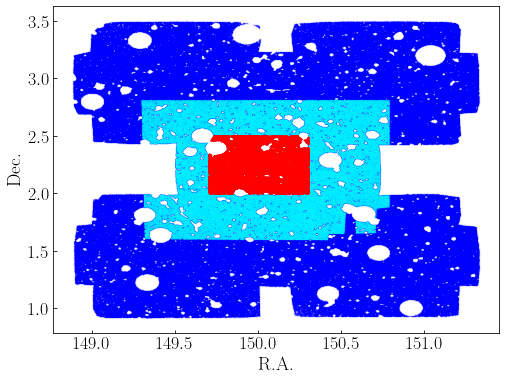

In [9]:
fig, axs = plt.subplots(1, 1, figsize = (8, 6),sharex=True, sharey=True)
cat_output_full_name = output_dir+'cat_out_15band_il.fits'
cat_output = Table.read(cat_output_full_name)

plt.scatter(cosmos_v9['RA'],cosmos_v9 ['DEC'],s=0.1,alpha=0.1,c='b')
plt.scatter(cosmos_v9[inside_j]['RA'],cosmos_v9[inside_j]['DEC'],s=0.1,alpha=0.1,c='cyan')
plt.scatter(cat_output['RA'],cat_output['DEC'],s=1,color='r')
plt.xlabel('R.A.',fontsize=19)
plt.ylabel('Dec.',fontsize=19)
plt.savefig('/Users/lejay/Desktop/smf_paper/sky_plot.png')


In [10]:
# total solid angle (all sky)
total_soid_angle = 360**2/np.pi

# COSMOS area
d_ra = 151.9 - 148.3
dec_1 = 0.6
dec_2 = 4.0
area = 360**2*(d_ra*np.pi/180.)*(np.sin(dec_2*np.pi/180.)-np.sin(dec_1*np.pi/180.))/ (4*np.pi**2) # solid angle, in square degrees
# masked area (estimate from random point catalog)
cat_random = Table.read('CUT_deep_catalogs/random_point_cat/COSMOS_deep_random_point.fits')
cat_random = cat_random[cat_random['RA'] > 148.3]
cat_random = cat_random[cat_random['RA'] < 151.9]
cat_random = cat_random[cat_random['DEC'] > 0.6]
cat_random = cat_random[cat_random['DEC'] < 4.0]
cat_random_nomask = cat_random[np.logical_and(cat_random['MASK']!=0, cat_random['inside']==0) ]
area = area * len(cat_random_nomask)/len(cat_random)
print("COSMOS", area)

# central COSMOS area (08squdeg)
d_ra = 150.6 - 149.7
dec_1 = 1.75
dec_2 = 2.65
area_central_cosmos = 360**2*(d_ra*np.pi/180.)*(np.sin(dec_2*np.pi/180.)-np.sin(dec_1*np.pi/180.))/ (4*np.pi**2) # solid angle, in square degrees
# masked area (estimate from random point catalog)
cat_random = Table.read('CUT_deep_catalogs/random_point_cat/COSMOS_deep_random_point.fits')
cat_random = cat_random[cat_random['RA'] > 149.7]
cat_random = cat_random[cat_random['RA'] < 150.6]
cat_random = cat_random[cat_random['DEC'] > 1.75]
cat_random = cat_random[cat_random['DEC'] < 2.65]
cat_random_nomask = cat_random[np.logical_and(cat_random['MASK']!=0, cat_random['inside']==0) ]
area_central_cosmos = area_central_cosmos * len(cat_random_nomask)/len(cat_random)
print("central COSMOS", area_central_cosmos)

# ELAIS area
d_ra = 245. - 240.
dec_1 = 53.3
dec_2 = 56.9
area_elais = 360**2*(d_ra*np.pi/180.)*(np.sin(dec_2*np.pi/180.)-np.sin(dec_1*np.pi/180.))/ (4*np.pi**2) # solid angle, in square degrees
# masked area (estimate from random point catalog)
cat_random = Table.read('CUT_deep_catalogs/random_point_cat/ELAIS_deep_random_point.fits')
cat_random = cat_random[cat_random['RA'] > 240]
cat_random = cat_random[cat_random['RA'] < 245]
cat_random = cat_random[cat_random['DEC'] > 53.3]
cat_random = cat_random[cat_random['DEC'] < 56.9]
cat_random_nomask = cat_random[np.logical_and(cat_random['MASK']!=0, cat_random['inside']==0) ]
area_elais = area_elais * len(cat_random_nomask)/len(cat_random)
print("ELAIS",area_elais)

# DEEP area
d_ra = 354. - 350.3
dec_1 = -1.6
dec_2 = 1
area_deep = 360**2*(d_ra*np.pi/180.)*(np.sin(dec_2*np.pi/180.)-np.sin(dec_1*np.pi/180.))/ (4*np.pi**2) # solid angle, in square degrees
# masked area (estimate from random point catalog)
cat_random = Table.read('CUT_deep_catalogs/random_point_cat/DEEP_deep_random_point.fits')
cat_random = cat_random[cat_random['RA'] > 350.3]
cat_random = cat_random[cat_random['RA'] < 354]
cat_random = cat_random[cat_random['DEC'] > -1.6]
cat_random = cat_random[cat_random['DEC'] < 1]
cat_random_nomask = cat_random[np.logical_and(cat_random['MASK']!=0, cat_random['inside']==0) ]
area_deep = area_deep * len(cat_random_nomask)/len(cat_random)
print("DEEP",area_deep)

# XMM area
d_ra = 37.8 - 33.6
dec_1 = -6.2
dec_2 = -3.2
area_xmm = 360**2*(d_ra*np.pi/180.)*(np.sin(dec_2*np.pi/180.)-np.sin(dec_1*np.pi/180.))/ (4*np.pi**2) # solid angle, in square degrees
# masked area (estimate from random point catalog)
cat_random = Table.read('CUT_deep_catalogs/random_point_cat/XMM-LSS_deep_random_point.fits')
cat_random = cat_random[cat_random['RA'] > 33.6]
cat_random = cat_random[cat_random['RA'] < 37.8]
cat_random = cat_random[cat_random['DEC'] > -6.2]
cat_random = cat_random[cat_random['DEC'] < -3.2]
cat_random_nomask = cat_random[np.logical_and(cat_random['MASK']!=0, cat_random['inside']==0) ]
area_xmm = area_xmm * len(cat_random_nomask)/len(cat_random)
print("XMM",area_xmm)

COSMOS 4.406492756179495
central COSMOS 0.6271818752015379
ELAIS 3.728927321927289
DEEP 3.7029813439273442
XMM 7.2547367302496015


#### comoving cosmic volume
$H_0=69.6$ km/s/Mpc, $\Omega_M=0.286$

In [11]:
V2 = 2.336 # cosmic volume at z=0.2, Gpc^3
V5 = 29.127
V8 = 94.303
V11 = 194.160
V15 = 365.540

Va = (V5-V2)*area/total_soid_angle*10**9 # in Mpc^3
Vb = (V8-V5)*area/total_soid_angle*10**9 # in Mpc^3
Vc = (V11-V8)*area/total_soid_angle*10**9 # in Mpc^3
Vd = (V15-V11)*area/total_soid_angle*10**9 # in Mpc^3
cosmic_volumes = [Va,Vb,Vc,Vd]

In [53]:
xp = [1,2,3,4]
fp = [1,4,9,16]
b= 2.5

np.interp(b,xp,fp)

6.5

In [124]:
mass_offset = np.load('mass_err/mass_err_median_all_0.8_1.1.npy')
mass_offset_x = mass_offset[0]
mass_offset_y = mass_offset[1]
print(mass_offset)

print(np.interp(9.6,mass_offset_x,mass_offset_y))

[[ 9.5    9.9   10.3   10.7   11.1   11.5  ]
 [-0.061 -0.024  0.025  0.054  0.073  0.119]
 [ 0.145  0.178  0.105  0.094  0.097  0.109]]
-0.05148500000000049


##### calculate the combined SMF

In [127]:
z_bins = 'original'
if z_bins == 'original':
    z_mins = [0.2, 0.5, 0.8, 1.1]
    z_maxs = [0.5, 0.8, 1.1, 1.5]
else: #'alt'
    z_mins = [0.2, 0.35, 0.7, 0.9]
    z_maxs = [0.35, 0.7, 0.9, 1.1]

mass_comp_80 = [8.2, 8.5, 9.1, 10]
mass_comp_sf_80 = [8.2, 8.5, 9.1, 10.]
mass_comp_q_80 = [8.5, 9.1, 9.9, 10.6]
fit_start_shift = [2,2,0,-5]
end_point = [-3,-3,-6,-3]

sigma_ms = [0.25,0.2,0.2,0.2] # one-sigma mass error to apply to convolution
num_bins = 50 # number of bin edges
bins = np.linspace(8,12.2,num_bins)
bin_size = bins[1]-bins[0]
bin_centers = bins[:-1]+bin_size/2
cat_comp = Table.read('comp_sigmoid_params.fits')

cat_type = 'all' # all, cosmos, central_cosmos or central_cosmos_v
if cat_type == 'all':
    cat_names = ['COSMOS_deep','DEEP_deep','ELAIS_deep']
    areas = [area, area_deep,area_elais]
elif cat_type == 'cosmos':
    cat_names = ['COSMOS_deep']
    areas = [area]
else:
    cat_names = ['COSMOS_deep']
    areas = [area_central_cosmos]

sfq = 'all'  # all,sf,q
phot_config = 'nonir'
z_outlier_corr = 'smooth'  # points or smooth or False
mass_offset_flag = True
comp_corr = False
fit_const_sigma = False

fit_params = []
fit_params_err = []
for i in range(len(z_mins)):
    total_area = 0

    x_total = np.zeros(num_bins-1)
    y_total = np.zeros(num_bins-1)
    yerr_minus_sq_total = np.zeros(num_bins-1)
    yerr_plus_sq_total = np.zeros(num_bins-1)
    for k,cat_name in enumerate(cat_names):
        print(z_mins[i],z_maxs[i],sfq, cat_name)
        
        # Read in catalog
        if cat_type == 'all' or cat_type == 'cosmos':
            cat = Table.read(graham_output_dir+cat_name+'_cat_out_nomaglimit_'+phot_config+'_il_nz_prior_formass_sfq_added.fits')
            z_keyname = 'Z_ML'
            m_keyname = 'MASS_MED_massrun'
        elif cat_type == 'centralcosmos':
            cat = Table.read(graham_output_dir+'cat_out_08squdeg_'+phot_config+'_il_nz_prior_nolimit_formass_sfq_added.fits')
            z_keyname = 'Z_ML'
            m_keyname = 'MASS_MED_massrun'
        else:
            cat = Table.read(dev_path+'input_cats/COSMOS_deep_base.fits') # use Vincet's redshift and mass here (ZPHOT and MASS_MED)
            z_keyname = 'ZPHOT'
            m_keyname = 'MASS_MED'
        print(cat_name, len(cat),round(len(cat)/areas[k],1))
        
        cond_ch1 = ( (cat['MAG_AUTO_CH1_CORR'] > 0.) & (cat['MAG_AUTO_CH1_CORR'] < 50.) & (cat['MAGERR_AUTO_CH1_CORR'] > 0.) & (cat['MAGERR_AUTO_CH1_CORR'] < 0.5) )
        cond_ch2 = ( (cat['MAG_AUTO_CH2_CORR'] > 0.) & (cat['MAG_AUTO_CH2_CORR'] < 50.) & (cat['MAGERR_AUTO_CH2_CORR'] > 0.) & (cat['MAGERR_AUTO_CH2_CORR'] < 0.5) )
        flag_irac = cond_ch1.astype(int) + cond_ch2.astype(int) 
        
        # flag for massive gals with no irac detection
        flag_wrongmassive = (cat['MASS_MED_massrun']>11.0) & (flag_irac<=1)
        cat = cat[flag_wrongmassive==False] # remove them
        flag_wrongmassive2 = (cat['MASS_MED_massrun']>11.0) & (cat['MAG_AUTO_CH1_CORR']>23)
        cat = cat[flag_wrongmassive2==False] # remove them
        
        cat_z = cat[cat[z_keyname]>z_mins[i]]
        cat_z = cat_z[cat_z[z_keyname]<z_maxs[i]]
        cat_z = cat_z[cat_z['MASK'] == 0]  # unmasked
        cat_z = cat_z[cat_z['OBJ_TYPE'] == 0]  # galaxies
        print(cat_name, len(cat_z),round(len(cat_z)/areas[k],1))
        
        # comepleteness values
        if sfq =='sf':
            comp_limit_index = bisect(bins, mass_comp_sf_80[i])
            cat_z = cat_z[cat_z['sfq_nuvrk_myrun']>0.5]
        elif sfq == 'q':
            comp_limit_index = bisect(bins, mass_comp_q_80[i])
            cat_z = cat_z[cat_z['sfq_nuvrk_myrun']<0.5]
        else:
            comp_limit_index = bisect(bins, mass_comp_80[i])
            
        # correction for masses (by m_myrun - m_c20 mass offset)
        if z_bins == 'original' and mass_offset_flag:
            # mass_offset = np.load('mass_err/mass_err_myrun_'+str(sfq)+'_'+str(z_mins[i])+'.npy')
            mass_offset = np.load('mass_err/mass_err_median_'+str(sfq)+'_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')
            mass_offset_x = mass_offset[0]
            mass_offset_y = mass_offset[1]
            for gal in cat_z:
                if gal['MASS_MED_massrun'] > 8:
                    gal['MASS_MED_massrun'] = gal['MASS_MED_massrun'] - np.interp(gal['MASS_MED_massrun'], mass_offset_x, mass_offset_y)
            
        # 1/vmax normalization
        inv_volumes = [] # sum of inverse of volumes
        for bin_num in tqdm(range(num_bins-1)):
            inv_volume = 0
            cat_massbin = cat_z[np.logical_and(cat_z[m_keyname]>bins[bin_num], cat_z[m_keyname]<bins[bin_num+1])]
            zmax_in_bin = p_sf[0]*bins[bin_num]**2 + p_sf[1]*bins[bin_num] + p_sf[2]
            if zmax_in_bin > z_maxs[i]:
                total_volume = ( cosmic_calc(z_maxs[i]) - cosmic_calc(z_mins[i]) )*1e9 # in Mpc^3
                inv_volume = len(cat_massbin) / (total_volume*areas[k]/total_soid_angle)
            else:
                max_gals_in_bin = 100
                if len(cat_massbin)> max_gals_in_bin:
                    select_ids = np.random.choice(np.arange(len(cat_massbin)), size=max_gals_in_bin, replace=False)
                    cat_select = cat_massbin[select_ids]
                else:
                    cat_select = cat_massbin
                    
                for gal in cat_select:
                    zmax = p_sf[0]*gal[m_keyname]**2 + p_sf[1]*gal[m_keyname] + p_sf[2]
                    total_volume = ( cosmic_calc(min(zmax,z_maxs[i])) - cosmic_calc(z_mins[i]) )*1e9 # in Mpc^3
                    inv_volume += 1 / (total_volume*areas[k]/total_soid_angle) * len(cat_massbin) / len(cat_select)
                    
            inv_volumes.append(inv_volume)            
        
        #### histograms (normalization and correction) 
        mass_list = cat_z[m_keyname]
        n,edges = np.histogram(mass_list,range=(8,12.2),bins=bins)
        sampling_factor = 1. 
        if sfq == 'sf':
            comp_param = cat_comp[4+i]
        elif sfq == 'q':
            comp_param = cat_comp[8+i]
        else:
            comp_param = cat_comp[i]
            
        completeness = sigmoid(bins[:-1]+bin_size/2, comp_param[2], comp_param[3])
        if comp_corr:
            weights = 1/bin_size/sampling_factor/completeness #completeness
        else:
            weights = 1/bin_size/sampling_factor
        x = bins[:-1]+np.diff(bins)/2       # log(M)
        y = np.array(inv_volumes)*weights   # density per mass bin
        
        # correction for redshift outliers
        if z_outlier_corr!='False' and z_bins == 'original':
            if z_outlier_corr == 'smooth':
                outlier_corr = np.load('outlier_corr_frac_'+sfq+'_'+str(z_mins[i])+'_smooth.npy')
            else:
                outlier_corr = np.load('outlier_corr_frac_'+sfq+'_'+str(z_mins[i])+'.npy')
            oc_x = outlier_corr[0] # mass at which outlier correction was sampled
            oc_y = outlier_corr[1] # outlier correction values
            oc_smfbins = np.interp(bin_centers,oc_x,oc_y) # interpolate
            y = y * oc_smfbins
       
        #### SMF uncertainty ###############
        if z_bins == 'original':
            # mass errorbars 
            arr = np.load('mass_err/mass_err_overall_'+str(sfq)+'_'+str(z_mins[i])+'.npy')
            mass_err_x = arr[0]
            mass_err_y = arr[1]
            hist_stack = []
            for r in range(20):
                mass_list_rand = mass_list + np.random.normal(0,np.interp(mass_list,mass_err_x,mass_err_y))
                hist,bin_edges = np.histogram(mass_list_rand,bins=bins)
                hist_stack.append(hist)
    
            mass_errbar_minus = np.mean(np.array(hist_stack),axis=0) - np.percentile(np.array(hist_stack),16,axis=0)
            mass_errbar_plus = np.percentile(np.array(hist_stack),84,axis=0) - np.mean(np.array(hist_stack),axis=0)
        
            # poisson errorbars
            poisson_errbar_minus = n - poisson_interval(n, a=0.3174)[0]
            poisson_errbar_plus = poisson_interval(n, a=0.3174)[1] - n
            
            # cosmic variance 
            cv = np.load('cosmic_variance/cv_'+str(z_mins[i])+'.npy')
            cv_x = cv[0] # mass at which cv was sampled
            cv_y = cv[1] # cv values (in percentage)
            cv_errbar_percentage = np.interp(bin_centers,cv_x,cv_y) # interpolate
            cv_errbar = n * cv_errbar_percentage/100
            
            # total SMF errorbars
            errbar_minus = np.sqrt(mass_errbar_minus**2 + poisson_errbar_minus**2 + cv_errbar**2)
            errbar_plus = np.sqrt(mass_errbar_plus**2 + poisson_errbar_plus**2 + cv_errbar**2)
            yerr_minus = errbar_minus/n * y
            yerr_minus[np.isnan(yerr_minus)]=1e-9
            yerr_plus = errbar_plus/n * y
            yerr_plus[np.isnan(yerr_plus)]=1e-9
        else:
            # total SMF errorbars
            errbar_minus = 1e-10*np.ones(len(y))
            errbar_plus = 1e-10*np.ones(len(y))
            yerr_minus = errbar_minus/n * y
            yerr_plus = errbar_plus/n * y
        
        # save to disk (field specific)
        y_err = (yerr_minus+yerr_plus)/2/areas[k]
        smf_field = np.stack([y, y_err, y_err/areas[k]]) 
        np.save('smf_'+cat_name+'_'+phot_config+'_'+sfq+'_'+str(z_mins[i])+'_'+str(z_maxs[i]), smf_field)
        
        ######## add up SMF ################
        total_area += areas[k]
        y_total += y*areas[k]
        yerr_minus_sq_total += yerr_minus**2*areas[k]**2
        yerr_plus_sq_total += yerr_plus**2*areas[k]**2
    
    # calculate overall SMF
    yerr_minus_total = np.sqrt(yerr_minus_sq_total)
    yerr_plus_total = np.sqrt(yerr_plus_sq_total)
    y_fitting = y_total/total_area
    y_fitting_err = (yerr_minus_total+yerr_plus_total)/2/total_area
    
    # save to disc
    smf_total = np.stack([y_fitting, y_fitting_err, yerr_plus_total/total_area]) 
    np.save('smf_'+phot_config+'_'+sfq+'_'+str(z_mins[i])+'_'+str(z_maxs[i]), smf_total)
    
    ######## SMF Fitting ##############
    
      # convolved schechter fit
#     # popt, pcov, chi2_ = fit_schechter_con(x,y,yerr,comp_limit_index+fit_start_shift[i],-5,0.15)
#     # print(popt)
#     # print(np.sqrt(np.diag(pcov)))
#     # x_plot = np.linspace(8,12.5,100)
#     # axs[row][col].plot(x_plot,schechter(x_plot,popt[0] ,popt[1], popt[2]),color='b',alpha=0.5)
#     # axs[row][col].plot(x_plot,con_schechter(x_plot, popt[0] ,popt[1], popt[2],0.15),color='b',alpha=0.5)

    # double schechter fit
#     popt, pcov, chi2_ = fit_double_schechter(bin_centers, y_fitting*1e3, y_fitting_err, comp_limit_index+fit_start_shift[i],end_point[i])
#     print(popt)
#     print(np.sqrt(np.diag(pcov)))
#     fit_params.append(popt)
#     fit_params_err.append(np.sqrt(np.diag(pcov))) 
    
    # convolved double schechter fit
#     if sfq=='q' and (i==2 or i==3):
#         double_fit = False
#     else:
#         double_fit = True
        
#     if fit_const_sigma:
#         popt, pcov, chi2_ = fit_double_schechter_con(bin_centers, y_fitting*1e3, y_fitting_err, comp_limit_index+fit_start_shift[i],end_point[i], sigma_ms[i],double_fit=double_fit)
#         fit_params.append(popt)
#         fit_params_err.append(np.sqrt(np.diag(pcov))) 
#     else:
#         popt, pcov, chi2_ = fit_double_schec_varysigma_con(bin_centers, y_fitting*1e3, y_fitting_err, comp_limit_index+fit_start_shift[i],end_point[i], z_mins[i],double_fit=double_fit)
#         fit_params.append(popt)
#         fit_params_err.append(np.sqrt(np.diag(pcov))) 
    
#     print(popt)
    
# if fit_const_sigma:    
#     np.save('fit_param_dsi_'+sfq,np.array(fit_params))
#     np.save('fit_param_err_dsi_'+sfq,np.array(fit_params_err))
# else:
#     np.save('fit_param_varysigma_'+sfq,np.array(fit_params))
#     np.save('fit_param_err_varysigma_'+sfq,np.array(fit_params_err)) 
    

0.2 0.5 all COSMOS_deep
COSMOS_deep 1357601 308091.1
COSMOS_deep 172595 39168.3


100%|██████████| 49/49 [00:02<00:00, 21.16it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:185: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in multiply
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:187: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:187: RuntimeWarning: invalid value encountered in multiply


0.2 0.5 all DEEP_deep
DEEP_deep 1090962 294617.2
DEEP_deep 142623 38515.7


100%|██████████| 49/49 [00:02<00:00, 19.15it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:185: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in multiply
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:187: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:187: RuntimeWarning: invalid value encountered in multiply


0.2 0.5 all ELAIS_deep
ELAIS_deep 1155513 309878.1
ELAIS_deep 121829 32671.3


100%|██████████| 49/49 [00:02<00:00, 18.32it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:185: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in multiply
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:187: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:187: RuntimeWarning: invalid value encountered in multiply


0.5 0.8 all COSMOS_deep
COSMOS_deep 1357601 308091.1
COSMOS_deep 255961 58087.2


100%|██████████| 49/49 [00:04<00:00,  9.81it/s]


0.5 0.8 all DEEP_deep
DEEP_deep 1090962 294617.2
DEEP_deep 225276 60836.4


100%|██████████| 49/49 [00:04<00:00, 10.54it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:185: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in multiply
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:187: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:187: RuntimeWarning: invalid value encountered in multiply


0.5 0.8 all ELAIS_deep
ELAIS_deep 1155513 309878.1
ELAIS_deep 248568 66659.4


100%|██████████| 49/49 [00:04<00:00, 10.06it/s]


0.8 1.1 all COSMOS_deep
COSMOS_deep 1357601 308091.1
COSMOS_deep 246596 55962.0


100%|██████████| 49/49 [00:07<00:00,  6.75it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:185: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in multiply
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:187: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:187: RuntimeWarning: invalid value encountered in multiply


0.8 1.1 all DEEP_deep
DEEP_deep 1090962 294617.2
DEEP_deep 185343 50052.4


100%|██████████| 49/49 [00:06<00:00,  7.86it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:185: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in multiply
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:187: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:187: RuntimeWarning: invalid value encountered in multiply


0.8 1.1 all ELAIS_deep
ELAIS_deep 1155513 309878.1
ELAIS_deep 186548 50027.3


100%|██████████| 49/49 [00:06<00:00,  7.33it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:185: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in multiply
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:187: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:187: RuntimeWarning: invalid value encountered in multiply


1.1 1.5 all COSMOS_deep
COSMOS_deep 1357601 308091.1
COSMOS_deep 187196 42481.9


100%|██████████| 49/49 [00:10<00:00,  4.72it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:185: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in multiply
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:187: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:187: RuntimeWarning: invalid value encountered in multiply


1.1 1.5 all DEEP_deep
DEEP_deep 1090962 294617.2
DEEP_deep 165297 44638.9


100%|██████████| 49/49 [00:07<00:00,  6.40it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:185: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in multiply
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:187: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:187: RuntimeWarning: invalid value encountered in multiply


1.1 1.5 all ELAIS_deep
ELAIS_deep 1155513 309878.1
ELAIS_deep 131933 35381.0


100%|██████████| 49/49 [00:07<00:00,  6.71it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:185: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in multiply
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:187: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:187: RuntimeWarning: invalid value encountered in multiply


#### Cosmic Variance

In [35]:
# cosmic variance
cat = Table.read(graham_output_dir+'COSMOS_deep_cat_out_nonir_il_22.4_formass_sfq_added.fits')
cat = cat[cat['MASK'] == 0]  # unmasked
cat = cat[cat['OBJ_TYPE'] == 0]  # galaxies

# ra/dec grid
grid = (2,3)
ra_min = 148.3
ra_max = 151.9
dec_min = 0.6
dec_max = 4.0
ra_list = np.linspace(ra_min,ra_max,grid[0]+1)
dec_list = np.linspace(dec_min,dec_max,grid[1]+1)

# add column to indicate grid spot
grid_data = np.zeros(len(cat))
grid_areas = []
count = 0
for i in range(len(ra_list)-1):
    ra_grid_min = ra_list[i]
    ra_grid_max = ra_list[i+1]
    for k in range(len(dec_list)-1):
        dec_grid_min = dec_list[k]
        dec_grid_max = dec_list[k+1]
        
        count += 1
        
        # cut catalog
        cond_ra = (cat['RA']>ra_grid_min) & (cat['RA']<ra_grid_max)
        cond_dec = (cat['DEC']>dec_grid_min) & (cat['DEC']<dec_grid_max)
        grid_data += count*(cond_ra.astype(int)*cond_dec.astype(int)) # grid spot number

        # area estimate for each grid
        area_grid = 360**2*((ra_grid_max-ra_grid_min)*np.pi/180.)*(np.sin(dec_grid_max*np.pi/180.)-np.sin(dec_grid_min*np.pi/180.))/ (4*np.pi**2) # solid angle, in square degrees
        cat_random = Table.read('CUT_deep_catalogs/random_point_cat/COSMOS_deep_random_point.fits')
        cat_random = cat_random[cat_random['RA'] > ra_grid_min]
        cat_random = cat_random[cat_random['RA'] < ra_grid_max]
        cat_random = cat_random[cat_random['DEC'] > dec_grid_min]
        cat_random = cat_random[cat_random['DEC'] < dec_grid_max]
        cat_random_nomask = cat_random[np.logical_and(cat_random['MASK']!=0, cat_random['inside']==0) ]
        area_grid = area_grid * len(cat_random_nomask)/len(cat_random)
        grid_areas.append(area_grid)
        
col_grid = Column(name='grid',data=grid_data)    
cat.add_column(col_grid)

0.2 0.5


  0%|          | 0/6 [00:00<?, ?it/s]


KeyError: 'grid'

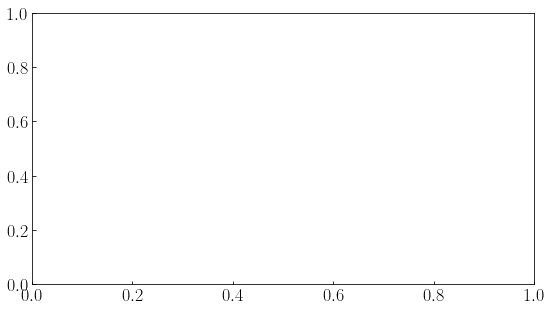

In [34]:
fig, axs = plt.subplots(1, 1, figsize = (9, 5),sharex=True)
mass_est_list = [9.5,10,10.5,11.0,11.5]
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]

for z_index in range(len(z_mins)):
    print(z_mins[z_index],z_maxs[z_index])
    cat_z = cat[cat['Z_ML']>z_mins[z_index]]
    cat_z = cat_z[cat_z['Z_ML']<z_maxs[z_index]]
    smf_scatter = []
    smf_scatter_std = []
    for i_exclude in tqdm(range(1,grid[0]*grid[1]+1)):
        smfs = []
        grid_exclude_indices = []
        for i in range(1,grid[0]*grid[1]+1): 
            # remove one grid spot at a time
            if i != i_exclude:
                if grid_areas[i-1]>0.001:
                    cat_cv=cat_z[cat_z['grid']==i]
                    area_cv = grid_areas[i-1]
                else:
                    grid_exclude_indices.append(i-1)
                    continue
            else:
                grid_exclude_indices.append(i-1)
                continue
            
            # mass offset correction
            cat_cv['MASS_MED_massrun'] = cat_cv['MASS_MED_massrun'] - 0.05
            
            # 1/vmax normalization
            num_bins = 50 # number of bin edges
            inv_volumes = [] # sum of inverse of volumes
            bins = np.linspace(8,12.2,num_bins)
            mass_bincenters = bins[:-1]+np.diff(bins)/2       # log(M)
            bin_size = bins[1]-bins[0]
            cat_comp = Table.read('comp_sigmoid_params.fits')   
            for bin_num in range(num_bins-1):
                inv_volume = 0
                cat_massbin = cat_cv[np.logical_and(cat_cv['MASS_MED_massrun']>bins[bin_num], cat_cv['MASS_MED_massrun']<bins[bin_num+1])]
                zmax_in_bin = p_sf[0]*bins[bin_num]**2 + p_sf[1]*bins[bin_num] + p_sf[2]
                if zmax_in_bin > 0.5:
                    total_volume = ( cosmic_calc(0.5) - cosmic_calc(0.2) )*1e9 # in Mpc^3
                    inv_volume = len(cat_massbin) / (total_volume*area_cv/total_soid_angle)
                else:
                    max_gals_in_bin = 100
                    if len(cat_massbin)> max_gals_in_bin:
                        select_ids = np.random.choice(np.arange(len(cat_massbin)), size=max_gals_in_bin, replace=False)
                        cat_select = cat_massbin[select_ids]
                    else:
                        cat_select = cat_massbin
                    
                    for gal in cat_select:
                        zmax = p_sf[0]*gal['MASS_MED_massrun']**2 + p_sf[1]*gal['MASS_MED_massrun'] + p_sf[2]
                        total_volume = ( cosmic_calc(min(zmax,0.5)) - cosmic_calc(0.2) )*1e9 # in Mpc^3
                        inv_volume += 1 / (total_volume*area_cv/total_soid_angle) * len(cat_massbin) / len(cat_select)
                
                inv_volumes.append(inv_volume)            
                
            #### histograms (normalization and correction) 
            mass_list = cat_cv['MASS_MED_massrun']
            n,edges = np.histogram(mass_list,range=(8,12.2),bins=bins)
            
            sampling_factor = 1. 
            comp_param = cat_comp[0]
            completeness = sigmoid(bins[:-1]+bin_size/2, comp_param[2], comp_param[3])
            weights = 1/bin_size/sampling_factor #completeness
            smf = np.array(inv_volumes)*weights   # density per mass bin    
            smfs.append(smf)
            plt.plot(mass_bincenters,smf,color='k',alpha=0.1)
        
        grid_areas_exclude1 = np.delete(grid_areas,grid_exclude_indices)
        weights_cv = grid_areas_exclude1/np.mean(grid_areas_exclude1)
        masked_smfs = np.ma.masked_array(smfs, np.isnan(smfs))
        

        smf_mean = np.average(masked_smfs, axis=0, weights=weights_cv)
        # smf_mean = np.average(smfs,axis=0, weights=weights_cv)
        smf_scatter = DescrStatsW(masked_smfs, weights=weights_cv, ddof=1).std
        
        # estimate smf scatter at different mass bins
        indices_smf = np.searchsorted(mass_bincenters,mass_est_list) 
        smf_scatter_std.append(smf_scatter[indices_smf]/smf_mean[indices_smf])
        
        # plot
        if i_exclude==1:
            plt.plot(mass_bincenters,smf_mean,color='b',alpha=1)
            plt.plot(mass_bincenters,smf_scatter,color='r',alpha=0.5)
            plt.yscale('log')
    
    cv_median = np.median(smf_scatter_std,axis=0)
    cv_16 = np.percentile(smf_scatter_std,16,axis=0)
    cv_84 = np.percentile(smf_scatter_std,84,axis=0)
    
    cv_mean = np.mean(smf_scatter_std,axis=0)
    cv_std = np.std(smf_scatter_std,axis=0)
    
    for mass_index,mass_estimate in enumerate(mass_est_list):
        # smf_cv = np.array([np.mean(grid_areas),cv_median[mass_index], cv_16[mass_index], cv_84[mass_index]]) # save to disc (median)
        smf_cv = np.array([np.mean(grid_areas),cv_mean[mass_index], cv_mean[mass_index]-cv_std[mass_index], cv_mean[mass_index]+cv_std[mass_index]]) # save to disc (mean)
        np.save('smf_cv/smf_cv2_all_'+str(z_mins[z_index])+'_'+str(z_maxs[z_index])+'_'+str(mass_estimate)+'_'+str(len(grid_areas)), smf_cv)
        print(mass_estimate,smf_cv)

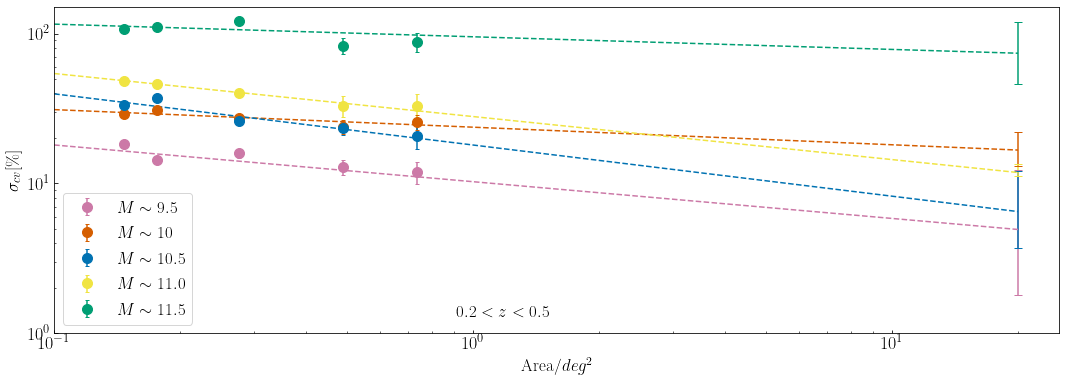

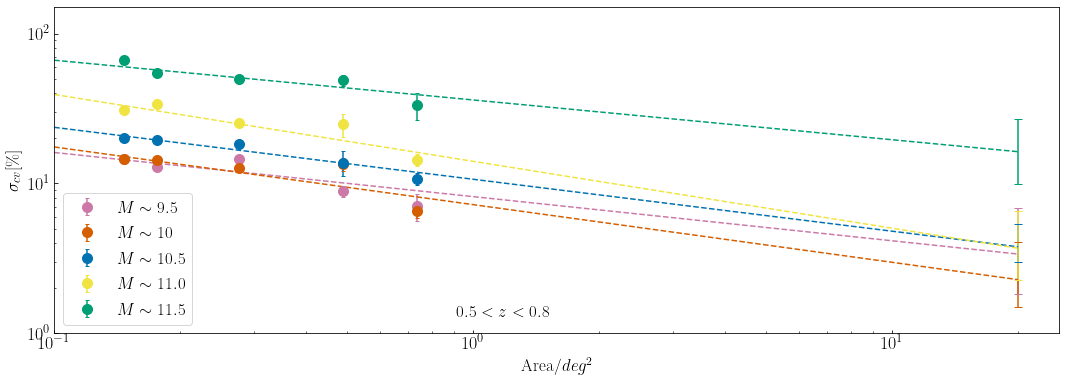

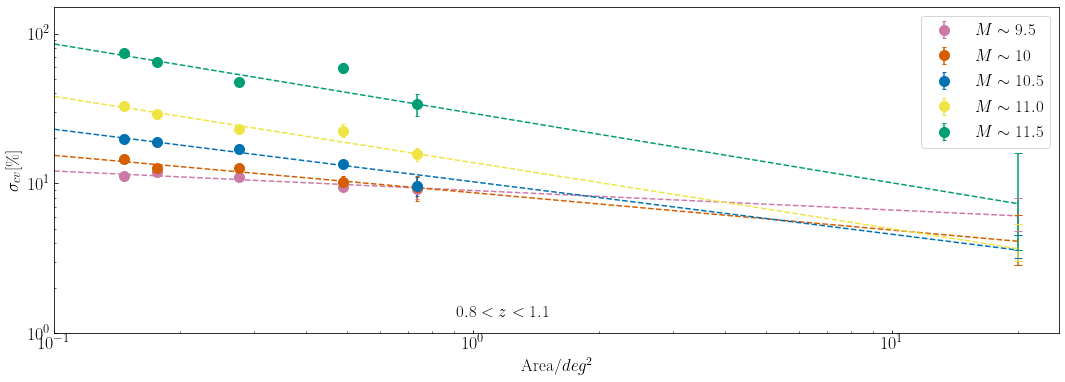

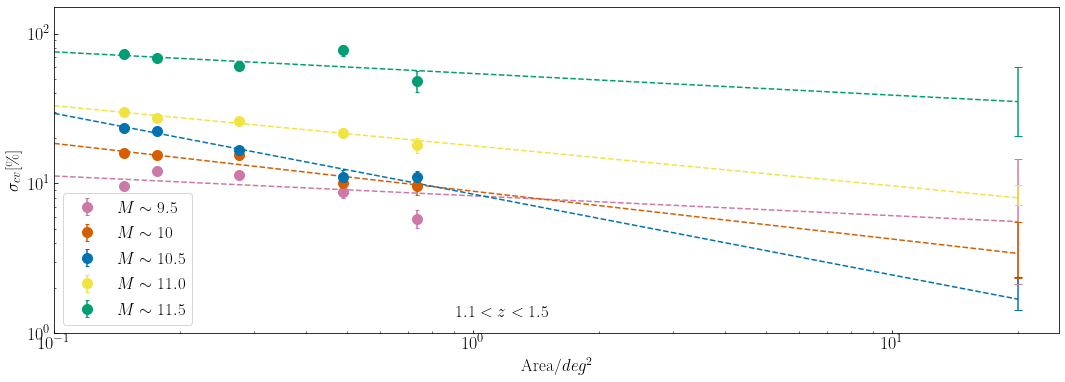

In [8]:
colors = ['#CC79A7','#D55E00','#0072B2','#F0E442','#009E73','#56B4E9','#E69F00']
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
mass_est_list = [9.5,10,10.5,11.0,11.5]
full_area = 20 # deg^2
for i in range(len(z_mins)): 
    fig, axs = plt.subplots(1, 1, figsize = (18, 6),sharex=True)
    cv_fullarea_list = []
    cv_fullarea_inf_list = []
    cv_fullarea_sup_list = []
    for k,mass in enumerate(mass_est_list):
        cv = []
        for patches in [6,9,16,25,30]:
            cv_1 = np.load('smf_cv/smf_cv2_all_'+str(z_mins[i])+'_'+str(z_maxs[i])+'_'+str(mass)+'_'+str(patches)+'.npy')
            if len(cv)==0:
                cv = cv_1
            else:
                cv = np.vstack([cv, cv_1])
        
        # measurements
        plt.errorbar(cv[:,0],cv[:,1]*100,yerr=((cv[:,1] - cv[:,2])*100,(cv[:,3] - cv[:,1])*100),fmt='o',color=colors[k], markersize=10, capsize=2,label='$M\sim '+str(mass)+'$')
        plt.xlim(0.1,25)
        plt.ylim(1,150)
        
        # fitting
        popt,pcov = curve_fit(power, cv[:,0], cv[:,1]*100, sigma = (cv[:,3] - cv[:,2])*100/2)
        arr = np.random.multivariate_normal(popt, pcov, 1000)
        cv_fullarea_samples = []
        for param in arr:
            cv_fullarea_samples.append(power(17,param[0],param[1]))
        
        cv_fullarea = np.median(cv_fullarea_samples,axis=0)
        cv_fullarea_inf = np.percentile(cv_fullarea_samples,16,axis=0)
        cv_fullarea_sup = np.percentile(cv_fullarea_samples,84,axis=0)
        cv_fullarea_list.append(cv_fullarea)
        cv_fullarea_inf_list.append(cv_fullarea_inf)
        cv_fullarea_sup_list.append(cv_fullarea_sup)
        
        # plot fitting
        x_plot = np.linspace(0.1,full_area,100)
        y_plot = power(x_plot,popt[0],popt[1])
        plt.plot(x_plot,y_plot,'--',color=colors[k])
        plt.errorbar(full_area,cv_fullarea,yerr=([cv_fullarea - cv_fullarea_inf],[cv_fullarea_sup-cv_fullarea]),capsize=4,color=colors[k])
    
    np.save('cosmic_variance/cv_'+str(z_mins[i])+'.npy',np.vstack([mass_est_list, cv_fullarea_list, cv_fullarea_inf_list, cv_fullarea_sup_list]))
    plt.annotate('$'+str(z_mins[i])+'<z<'+str(z_maxs[i])+'$',xy=([0.4,0.05]),xycoords='axes fraction',fontsize=17,color='k')
    plt.xlabel('Area/$deg^2$',fontsize=17)
    plt.ylabel('$\sigma_{cv}[\%]$',fontsize=17)
    plt.yscale('log')
    plt.xscale('log')
    plt.legend(fontsize=17)
    plt.show()

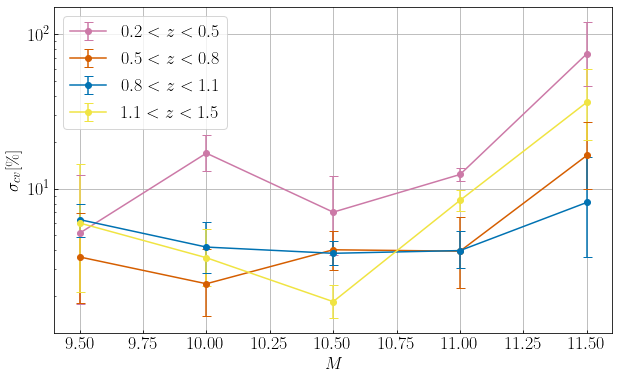

In [20]:
fig, axs = plt.subplots(1, 1, figsize = (10, 6),sharex=True)
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]

colors = ['#CC79A7','#D55E00','#0072B2','#F0E442','#009E73','#56B4E9','#E69F00']
for i in range(len(z_mins)): 
    cv_full_area = np.load('cosmic_variance/cv_'+str(z_mins[i])+'.npy')
    axs.errorbar(mass_est_list, cv_full_area[1,:], yerr=(cv_full_area[1,:]-cv_full_area[2,:],cv_full_area[3,:]-cv_full_area[1,:]), fmt='o-', capsize=4.5, color=colors[i],label='$'+str(z_mins[i])+'<z<'+str(z_maxs[i])+'$')
    axs.set_xlabel('$M$',fontsize=17)
    axs.set_ylabel('$\sigma_{cv}[\%]$',fontsize=17)
    axs.set_yscale('log')
    axs.grid(True)
    axs.legend(fontsize=18)

#### Fitting Results

In [77]:
# check difference between me and literature
# 0.8<z<1.1
bins = np.linspace(8,12.2,num_bins)
bin_size = bins[1]-bins[0]
zrange = '0.8_1.1'

smf = np.load('smf_nonir_all_'+zrange+'.npy')
x = bins[:-1]+bin_size/2
y = smf[0]

smf_we =  np.load('smf_lit/smf_we_'+zrange+'.npy')
x_we = smf_we[:,0]
y_we = 10**smf_we[:,1]

m_check = 10.7
my_value = np.interp(m_check,x,y)
weaver_value = np.interp(m_check,x_we,y_we)
print('my value',round(my_value,6),'Weaver+22 value',round(weaver_value,6))
print('ratio',round(my_value/weaver_value,3))

my value 0.00195 Weaver+22 value 0.002428
ratio 0.803


/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle sepa

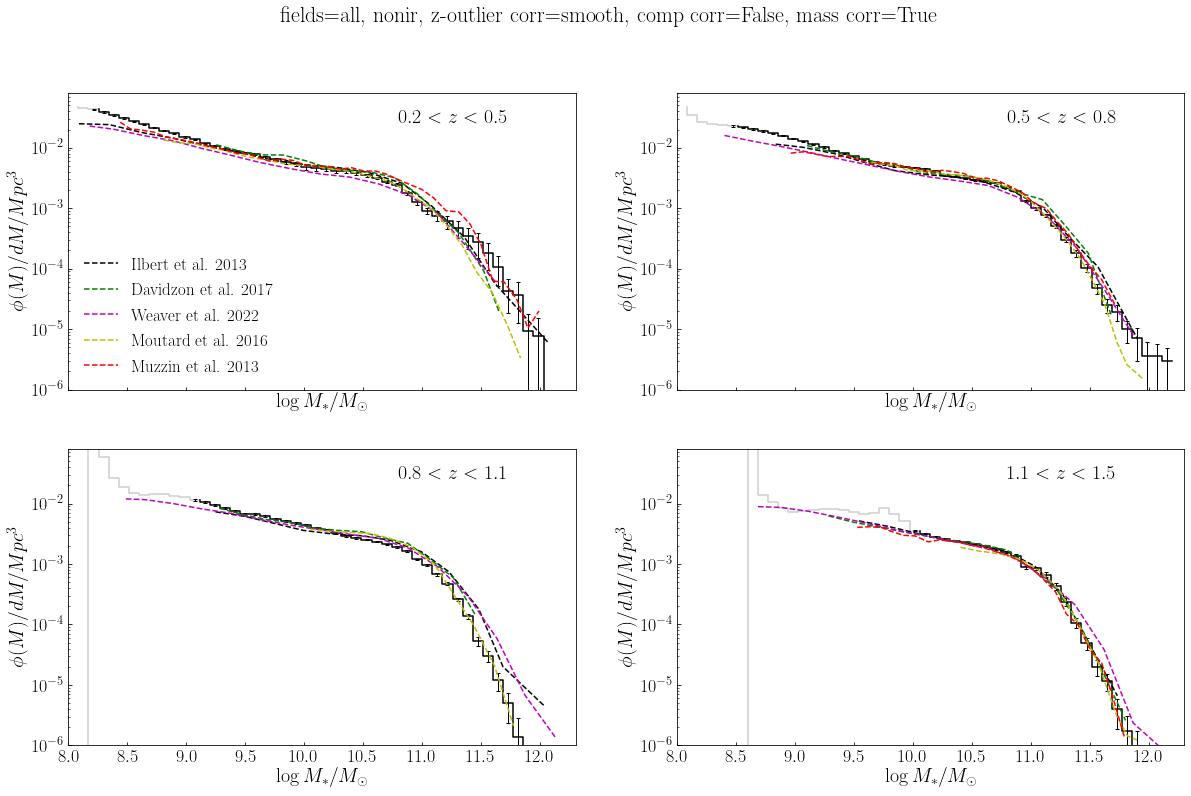

In [130]:
# plot
fig, axs = plt.subplots(2, 2, figsize = (20, 12),sharex=True)
plt.suptitle('fields='+cat_type+', '+phot_config+', z-outlier corr='+str(z_outlier_corr)+', comp corr='+str(comp_corr)+', mass corr='+str(mass_offset_flag),fontsize=22)

if z_bins == 'original':
    z_mins = [0.2, 0.5, 0.8, 1.1]
    z_maxs = [0.5, 0.8, 1.1, 1.5]
else: #'alt'
    z_mins = [0.2, 0.35, 0.7, 0.9]
    z_maxs = [0.35, 0.7, 0.9, 1.1]
    
mass_shift = [0.04, 0.05, 0.07, 0.08]
mass_comp_80 = [8.2, 8.5, 9.1, 10]
sigma_ms = [0.25,0.2,0.2,0.2]
num_bins = 50 # number of bin edges
bins = np.linspace(8,12.2,num_bins)
bin_size = bins[1]-bins[0]
cat_comp = Table.read('comp_sigmoid_params.fits')

sfq='all'
fit_const_sigma = False
for i in range(len(z_mins)):       
    row = i//2
    col = i%2
    
    # load smf data 
    smf = np.load('smf_'+phot_config+'_'+sfq+'_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')
    x = bins[:-1]+bin_size/2
    y = smf[0]
    yerr_plus = smf[1]
    yerr_minus = smf[2]
        
    # the plot
    comp_limit_index = bisect(bins, mass_comp_80[i])
    axs[row][col].plot(bins[:comp_limit_index]+bin_size,y[:comp_limit_index],ls='steps',color='k',alpha=0.2)
    axs[row][col].plot(bins[comp_limit_index-1:-1]+bin_size,y[comp_limit_index-1:],ls='steps',color='k')
    axs[row][col].errorbar(bins[comp_limit_index-1:-1]+bin_size/2, y[comp_limit_index-1:], yerr=(yerr_minus[comp_limit_index-1:],yerr_plus[comp_limit_index-1:]) , color='k',linewidth=1,capsize=2,linestyle='')
    
    # Literature Results
    if z_bins == 'original':
        # compare to ilbert+2013 results
        smf_il =  np.load('smf_lit/smf_il_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')
        axs[row][col].plot(smf_il[:,0],10**smf_il[:,1],'--',color='k',label='Ilbert et al. 2013')
        
        # compare to Davidzon+2017 results
        smf_da =  np.load('smf_lit/smf_da_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')
        axs[row][col].plot(smf_da[:,0],10**smf_da[:,1],'--',color='g',label='Davidzon et al. 2017')
        
        # compare to Weaver+2022 results
        smf_we =  np.load('smf_lit/smf_we_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')
        axs[row][col].plot(smf_we[:,0],10**smf_we[:,1],'--',color='m',label='Weaver et al. 2022')
        
        # compare to moutard+2016 results
        smf_mo =  np.load('smf_lit/smf_mo_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')
        axs[row][col].plot(smf_mo[:,0],10**smf_mo[:,1],'--',color='y',label='Moutard et al. 2016')
    
    #fitting results
    # x_plot = np.linspace(8,12.5,100)
    # if fit_const_sigma:
    #     popt = np.load('fit_param_dsi_'+sfq+'.npy')[i]
    #     axs[row][col].plot(x_plot,double_schechter(x_plot,popt[0] ,popt[1]/1e3, popt[2],popt[3]/1e3, popt[4]),color='b',alpha=0.5)
    #     axs[row][col].plot(x_plot,con_double_schechter(x_plot, popt[0], popt[1]/1e3, popt[2],popt[3]/1e3, popt[4],popt[5]),color='b',alpha=0.5)
    # else:
    #     popt = np.load('fit_param_varysigma_'+sfq+'.npy')[i]
    #     axs[row][col].plot(x_plot,double_schechter(x_plot,popt[0] ,popt[1]/1e3, popt[2],popt[3]/1e3, popt[4]),color='b',alpha=0.5)
    #     axs[row][col].plot(x_plot,con_double_schec_varysigma(x_plot, popt[0], popt[1]/1e3, popt[2],popt[3]/1e3, popt[4],popt[5]),color='b',alpha=0.5)
    
    # popt = np.load('fit_param_dsi_'+sfq+'.npy')[i]
    # axs[row][col].plot(x_plot,double_schechter(x_plot,popt[0] ,popt[1]/1e3, popt[2],popt[3]/1e3, popt[4]),color='b',alpha=0.5)
    
    axs[row][col].set_xlabel('$\log M_*/M_\odot$',fontsize=20)
    axs[row][col].set_ylabel('$\phi(M)/dM/Mpc^3$',fontsize=20)
    axs[row][col].set_yscale('log')
    axs[row][col].set_xlim([8,12.3])
    axs[row][col].set_ylim([1e-6,8e-2])
    axs[row][col].annotate('$'+str(z_mins[i])+'<z<'+str(z_maxs[i])+'$',xy=([0.65,0.9]),xycoords='axes fraction',fontsize=20,color='k')

if z_bins == 'original':
    smf_mu =  np.load('smf_lit/smf_mu_0.2_0.5.npy')
    axs[0][0].plot(smf_mu[:,0],10**smf_mu[:,1],'--',color='r',label='Muzzin et al. 2013')
    smf_mu =  np.load('smf_lit/smf_mu_0.5_1.0.npy')
    axs[0][1].plot(smf_mu[:,0],10**smf_mu[:,1],'--',color='r',label='Muzzin et al. 2013')
    
    smf_mu =  np.load('smf_lit/smf_mu_1.0_1.5.npy')
    axs[1][1].plot(smf_mu[:,0],10**smf_mu[:,1],'--',color='r',label='Muzzin et al. 2013')
    axs[0][0].legend(fontsize=17,frameon=False)

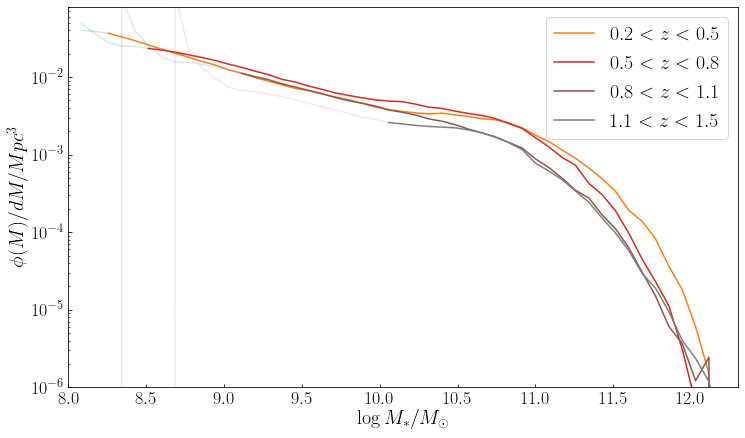

In [13]:
# overplot SMF from all bins
fig, axs = plt.subplots(1, 1, figsize = (12, 7))
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
mass_shift = [0.04, 0.05, 0.07, 0.08]
mass_comp_80 = [8.2, 8.5, 9.1, 10]
sigma_ms = [0.25,0.2,0.2,0.2]
num_bins = 50 # number of bin edges
bins = np.linspace(8,12.2,num_bins)
bin_size = bins[1]-bins[0]
cat_comp = Table.read('comp_sigmoid_params.fits')
phot_config = 'nonirirac'

for i in range(len(z_mins)):       
    # load smf data
    smf = np.load('smf_'+phot_config+'_all_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')
    x = bins[:-1]+bin_size/2
    y = smf[0]
    yerr_plus = smf[1]
    yerr_minus = smf[2]
    
    # the plot
    comp_limit_index = bisect(bins, mass_comp_80[i])
    plt.plot(bins[:comp_limit_index]+bin_size,y[:comp_limit_index],alpha=0.2)
    plt.plot(bins[comp_limit_index-1:-1]+bin_size,y[comp_limit_index-1:],label='$'+str(z_mins[i])+'<z<'+str(z_maxs[i])+'$')
    # plt.errorbar(bins[comp_limit_index-1:-1]+bin_size/2, y[comp_limit_index-1:], yerr=(yerr_minus[comp_limit_index-1:],yerr_plus[comp_limit_index-1:]) , color='k',linewidth=1,capsize=2,linestyle='')
    
    plt.xlabel('$\log M_*/M_\odot$',fontsize=20)
    plt.ylabel('$\phi(M)/dM/Mpc^3$',fontsize=20)
    plt.yscale('log')
    plt.xlim([8,12.3])
    plt.ylim([1e-6,8e-2])
    plt.legend(fontsize=20)

#### All Fields
COSMOS DEEP ELAIS

/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyl

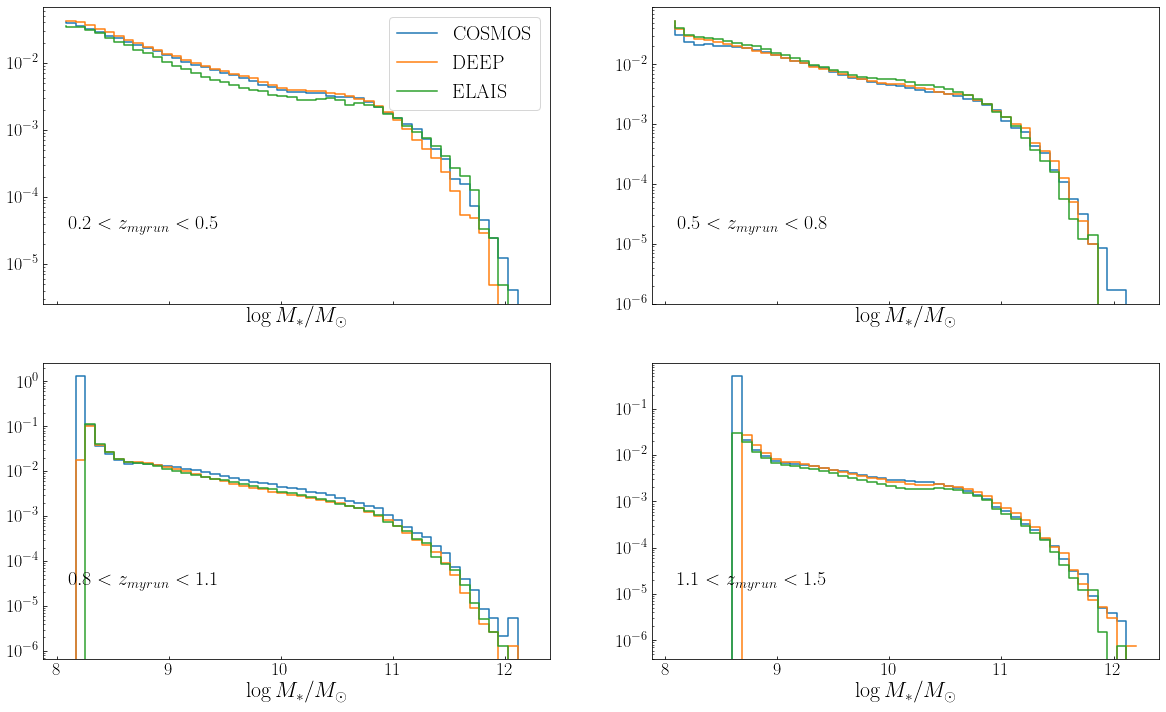

In [85]:
fig, axs = plt.subplots(2, 2, figsize = (20, 12),sharex=True)
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
areas = [area, area_deep,area_elais]
for i,z_min in enumerate(z_mins):
    row = i//2
    col = i%2
    for k, cat_name in enumerate(['COSMOS_deep','DEEP_deep','ELAIS_deep']):
        smf = np.load('smf_'+cat_name+'_nonir_all_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')
        
        # plot data
        x = bins[:-1]+np.diff(bins)/2
        y = smf[0]
        axs[row][col].plot(bins[:-1]+bin_size,y,ls='steps',label=cat_name.replace('_deep',''))
        
    axs[row][col].annotate('$'+str(z_mins[i])+'<z_{myrun}<'+str(z_maxs[i])+'$',xy=([0.05,0.24]),xycoords='axes fraction',fontsize=20,color='k')
    axs[row][col].set_yscale('log')
    axs[row][col].set_xlabel('$\log M_*/M_\odot$',fontsize=22)
    axs[0][0].legend(fontsize=20)    

/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle sepa

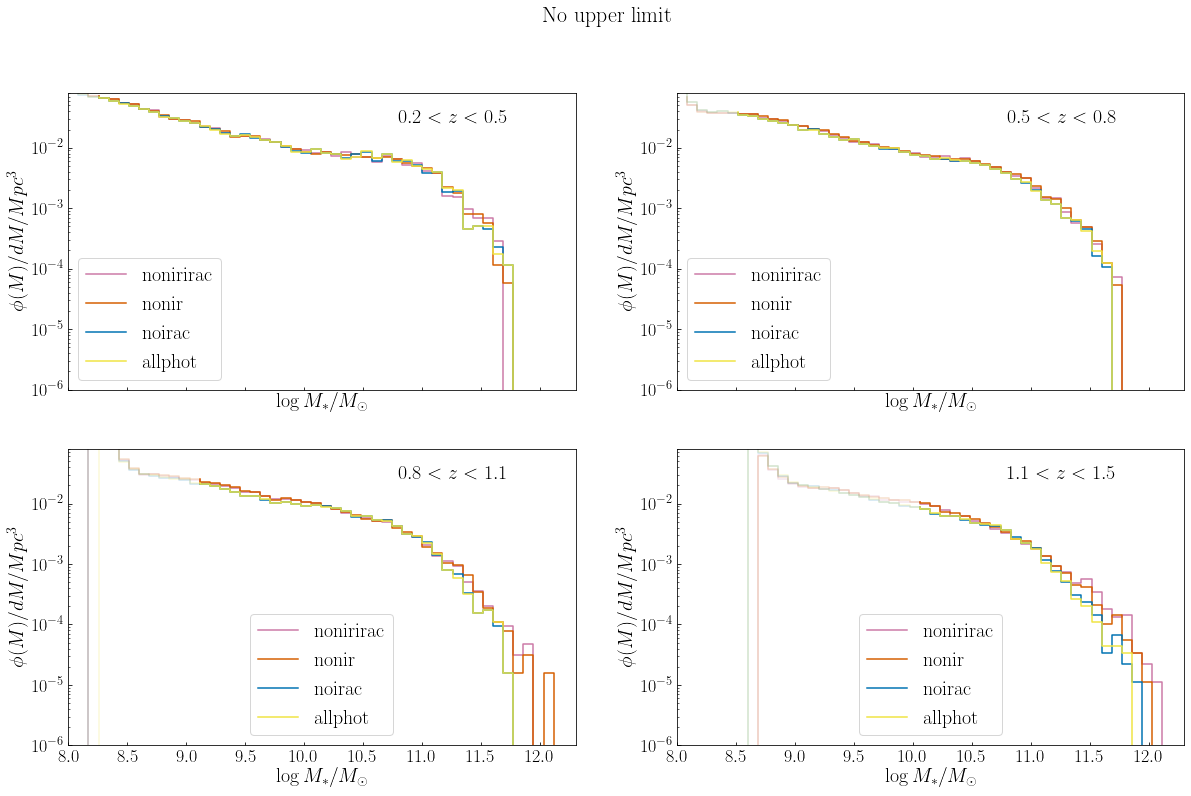

In [31]:
# comparing SMF with diff. phot configs

fig, axs = plt.subplots(2, 2, figsize = (20, 12),sharex=True)
plt.suptitle('No upper limit',fontsize=22)

z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
mass_shift = [0.04, 0.05, 0.07, 0.08]
mass_comp_80 = [8.2, 8.5, 9.1, 10]
sigma_ms = [0.25,0.2,0.2,0.2]
num_bins = 50 # number of bin edges
bins = np.linspace(8,12.2,num_bins)
bin_size = bins[1]-bins[0]
cat_comp = Table.read('comp_sigmoid_params.fits')

sfq='all'
fit_const_sigma = False
for i in range(len(z_mins)):       
    row = i//2
    col = i%2
    
    # load smf data
    colors = ['#CC79A7','#D55E00','#0072B2','#F0E442','#009E73','#56B4E9','#E69F00']
    for k, phot_config in enumerate(['nonirirac','nonir','noirac','allphot']):
        smf = np.load('smf_'+phot_config+'_'+sfq+'_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')
        x = bins[:-1]+bin_size/2
        y = smf[0]*2
        yerr_plus = smf[1]*2
        yerr_minus = smf[2]*2

        # the plot
        comp_limit_index = bisect(bins, mass_comp_80[i])
        axs[row][col].plot(bins[:comp_limit_index]+bin_size,y[:comp_limit_index],ls='steps',color=colors[k],alpha=0.2)
        axs[row][col].plot(bins[comp_limit_index-1:-1]+bin_size,y[comp_limit_index-1:],ls='steps',color=colors[k],label=phot_config)
        # axs[row][col].errorbar(bins[comp_limit_index-1:-1]+bin_size/2, y[comp_limit_index-1:], yerr=(yerr_minus[comp_limit_index-1:],yerr_plus[comp_limit_index-1:]) , color=colors[k],linewidth=1,capsize=2,linestyle='')
    
    axs[row][col].set_xlabel('$\log M_*/M_\odot$',fontsize=20)
    axs[row][col].set_ylabel('$\phi(M)/dM/Mpc^3$',fontsize=20)
    axs[row][col].set_yscale('log')
    axs[row][col].set_xlim([8,12.3])
    axs[row][col].set_ylim([1e-6,8e-2])
    axs[row][col].legend(fontsize=20)
    axs[row][col].annotate('$'+str(z_mins[i])+'<z<'+str(z_maxs[i])+'$',xy=([0.65,0.9]),xycoords='axes fraction',fontsize=20,color='k')

/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle sepa

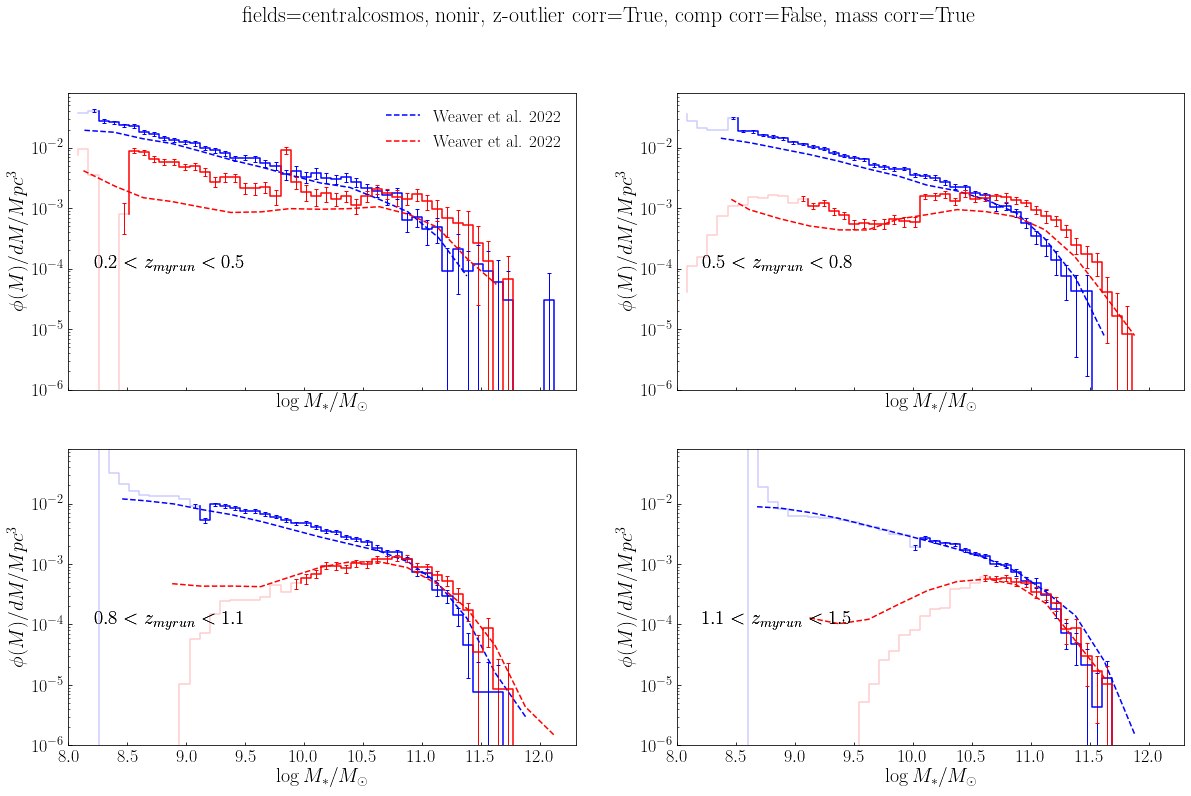

In [107]:
# plot
fig, axs = plt.subplots(2, 2, figsize = (20, 12),sharex=True)
plt.suptitle('fields='+cat_type+', '+phot_config+', z-outlier corr='+str(z_outlier_corr)+', comp corr='+str(comp_corr)+', mass corr='+str(mass_offset_flag),fontsize=22)

z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
mass_shift = [0.04, 0.05, 0.07, 0.08]
mass_comp_80 = [8.2, 8.5, 9.1, 10]
mass_comp_sf_80 = [8.2, 8.5, 9.1, 10.]
mass_comp_q_80 = [8.5, 9.1, 9.9, 10.6]
fit_start_shift = [2,2,0,-5]
end_point = [-3,-3,-6,-3]
sigma_ms = [0.25,0.2,0.2,0.2]
num_bins = 50 # number of bin edges
bins = np.linspace(8,12.2,num_bins)
bin_size = bins[1]-bins[0]
cat_comp = Table.read('comp_sigmoid_params.fits')

fit_params = []
fit_params_err = []
for i in range(len(z_mins)):       
    row = i//2
    col = i%2
    colors = ['b','r']
    for k,sfq in enumerate(['sf','q']):
        smf = np.load('smf_'+phot_config+'_'+sfq+'_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')
        x = bins[:-1]+bin_size/2
        y = smf[0]
        yerr_plus = smf[1]
        yerr_minus = smf[2]
        
        if sfq=='sf':
            comp_limit_index = bisect(bins, mass_comp_sf_80[i])
        else:
            comp_limit_index = bisect(bins, mass_comp_q_80[i])
        axs[row][col].plot(bins[:comp_limit_index]+bin_size,y[:comp_limit_index],ls='steps',color=colors[k],alpha=0.2)
        axs[row][col].plot(bins[comp_limit_index-1:-1]+bin_size,y[comp_limit_index-1:],ls='steps',color=colors[k])
        axs[row][col].errorbar(bins[comp_limit_index-1:-1]+bin_size/2, y[comp_limit_index-1:], yerr=(yerr_minus[comp_limit_index-1:],yerr_plus[comp_limit_index-1:]) , color=colors[k],linewidth=1,capsize=2,linestyle='')
    
        #compare to moutard+2016 results
        # if sfq =='sf':
        #     smf_mo =  np.load('smf_lit/smf_mo_sf_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')
        #     axs[row][col].plot(smf_mo[:,0],10**smf_mo[:,1],'--',color='b',label='Moutard et al. 2016')
        # else:
        #     smf_mo =  np.load('smf_lit/smf_mo_q_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')
        #     axs[row][col].plot(smf_mo[:,0],10**smf_mo[:,1],'--',color='r',label='Moutard et al. 2016')         
        
        # compare to Weaver+2022 results
        if sfq =='sf':
            smf_we =  np.load('smf_lit/smf_we_sf_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')
            axs[row][col].plot(smf_we[:,0],10**smf_we[:,1],'--',color='b',label='Weaver et al. 2022')
        else:
            smf_we =  np.load('smf_lit/smf_we_q_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')
            axs[row][col].plot(smf_we[:,0],10**smf_we[:,1],'--',color='r',label='Weaver et al. 2022')           
        
        # fit with model
        # x_plot = np.linspace(8,12.5,100)
        # if fit_const_sigma:
        #     popt = np.load('fit_param_dsi_'+sfq+'.npy')[i]
        #     axs[row][col].plot(x_plot,double_schechter(x_plot,popt[0] ,popt[1]/1e3, popt[2],popt[3]/1e3, popt[4]),colors[k],alpha=0.5)
        #     axs[row][col].plot(x_plot,con_double_schechter(x_plot, popt[0], popt[1]/1e3, popt[2],popt[3]/1e3, popt[4],popt[5]),colors[k],alpha=0.5)
        # else:
        #     popt = np.load('fit_param_varysigma_'+sfq+'.npy')[i]
        #     axs[row][col].plot(x_plot,double_schechter(x_plot,popt[0] ,popt[1]/1e3, popt[2],popt[3]/1e3, popt[4]),colors[k],alpha=0.5)
        #     axs[row][col].plot(x_plot,con_double_schec_varysigma(x_plot, popt[0], popt[1]/1e3, popt[2],popt[3]/1e3, popt[4],popt[5]),colors[k],alpha=0.5)
    
        axs[row][col].set_xlabel('$\log M_*/M_\odot$',fontsize=20)
        axs[row][col].set_ylabel('$\phi(M)/dM/Mpc^3$',fontsize=20)
        axs[row][col].set_yscale('log')
        axs[row][col].set_xlim([8,12.3])
        axs[row][col].set_ylim([1e-6,8e-2])
        axs[row][col].annotate('$'+str(z_mins[i])+'<z_{myrun}<'+str(z_maxs[i])+'$',xy=([0.05,0.4]),xycoords='axes fraction',fontsize=20,color='k')



# Muzzin+2013
# smf_mu =  np.load('smf_mu_sf_0.2_0.5.npy')
# axs[0][0].plot(smf_mu[:,0],10**smf_mu[:,1],'.-',color='b',label='Muzzin et al. 2013')
# smf_mu =  np.load('smf_mu_sf_0.5_1.0.npy')
# axs[0][1].plot(smf_mu[:,0],10**smf_mu[:,1],'.-',color='b')
# smf_mu =  np.load('smf_mu_sf_1.0_1.5.npy')
# axs[1][1].plot(smf_mu[:,0],10**smf_mu[:,1],'.-',color='b')

# smf_mu =  np.load('smf_mu_q_0.2_0.5.npy')
# axs[0][0].plot(smf_mu[:,0],10**smf_mu[:,1],'.-',color='r')
# smf_mu =  np.load('smf_mu_q_0.5_1.0.npy')
# axs[0][1].plot(smf_mu[:,0],10**smf_mu[:,1],'.-',color='r')
# smf_mu =  np.load('smf_mu_q_1.0_1.5.npy')
# axs[1][1].plot(smf_mu[:,0],10**smf_mu[:,1],'.-',color='r')
# axs[0][0].legend(fontsize=17,frameon=False)

axs[0][0].legend(fontsize=17,frameon=False)

In [492]:
arr = np.load('fit_param_varysigma_q.npy')
print(arr[2])

arr_err = np.load('fit_param_err_varysigma_q.npy')
print(arr_err[2])

[ 1.087e+01  8.859e-01  9.752e-01  4.024e-01 -1.289e-09  8.000e-01]
[0.121 0.967 1.122 1.053 0.814 0.   ]


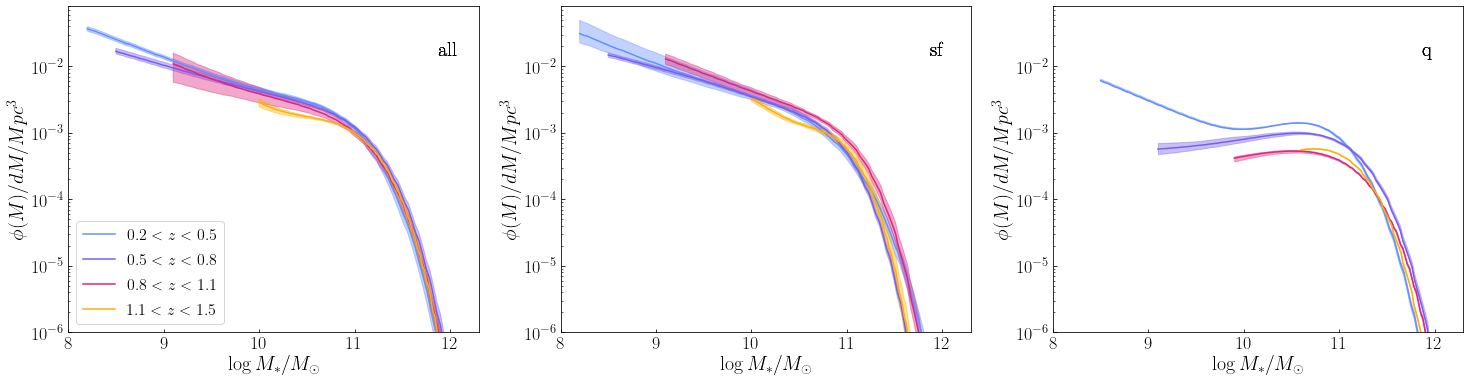

In [16]:
# evolution of SMF (fit)
colors = ['#648FFF','#785EF0','#DC267F','#FFB000']
fig, axs = plt.subplots(1, 3, figsize = (25, 6),sharex=True)
mass_comp_80 = [8.2, 8.5, 9.1, 10]
mass_comp_sf_80 = [8.2, 8.5, 9.1, 10.]
mass_comp_q_80 = [8.5, 9.1, 9.9, 10.6]
fit_const_sigma = False

for i,sfq in enumerate(['all','sf','q']):
    if fit_const_sigma:
        fit_params = np.load('fit_param_dsi_'+sfq+'.npy')
        fit_params_err = np.load('fit_param_err_dsi_'+sfq+'.npy')
    else:
        fit_params = np.load('fit_param_varysigma_'+sfq+'.npy')
        fit_params_err = np.load('fit_param_err_varysigma_'+sfq+'.npy')
    
    for k in [0,1,2,3]:  # redshift bin number
        # smf = np.load('smf_'+sfq+'_'+str(z_mins[k])+'_'+str(z_maxs[k])+'.npy')
        # y = smf[0]
        # yerr_plus = smf[1]
        # yerr_minus = smf[2]
    
        y_list = []
        if sfq =='sf':
            x_plot = np.linspace(mass_comp_sf_80[k],12.2,100)
        elif sfq == 'q':
            x_plot = np.linspace(mass_comp_q_80[k],12.2,100)
        else:
            x_plot = np.linspace(mass_comp_80[k],12.2,100)
        
        for j in range(30):
            if sfq =='q':
                err_factor = 0.3
            else:
                err_factor = 1
            popt_j = fit_params[k] + (np.random.rand(6)-0.5)*2*err_factor*fit_params_err[k]
            if fit_const_sigma:
                y = con_double_schechter(x_plot, popt_j[0], popt_j[1]/1e3, popt_j[2],popt_j[3]/1e3, popt_j[4],popt_j[5])
            else:
                y = con_double_schec_varysigma(x_plot, popt_j[0], popt_j[1]/1e3, popt_j[2],popt_j[3]/1e3, popt_j[4],z_mins[k])
            y_list.append(y)
        
        y_median = np.median(y_list,axis=0)
        y_16 = np.percentile(y_list,16,axis=0)
        y_84 = np.percentile(y_list,84,axis=0)
    
        popt = fit_params[k]
        # axs[i].plot(x_plot, double_schechter(x_plot, popt[0], popt[1]/1e3, popt[2],popt[3]/1e3, popt[4]),color = colors[k],label='$'+str(z_mins[k])+'<z_{myrun}<'+str(z_maxs[k])+'$')
        if fit_const_sigma:
            y_plot = con_double_schechter(x_plot, popt[0], popt[1]/1e3, popt[2],popt[3]/1e3, popt[4],popt[5])
            # y_plot = double_schechter(x_plot, popt[0], popt[1]/1e3, popt[2],popt[3]/1e3, popt[4])
            axs[i].plot(x_plot, y_plot, color = colors[k],label='$'+str(z_mins[k])+'<z<'+str(z_maxs[k])+'$')
        else:
            y_plot = con_double_schec_varysigma(x_plot, popt[0], popt[1]/1e3, popt[2],popt[3]/1e3, popt[4],z_mins[k])
            # y_plot = double_schechter(x_plot, popt[0], popt[1]/1e3, popt[2],popt[3]/1e3, popt[4])
            axs[i].plot(x_plot, y_plot,color = colors[k],label='$'+str(z_mins[k])+'<z<'+str(z_maxs[k])+'$')
        axs[i].fill_between(x_plot,y_16,y_84,color = colors[k],alpha=0.4)
        
        axs[i].annotate(sfq,xy=([0.9,0.85]),xycoords='axes fraction',fontsize=20,color='k')
    
    axs[i].set_xlabel('$\log M_*/M_\odot$',fontsize=20)
    axs[i].set_ylabel('$\phi(M)/dM/Mpc^3$',fontsize=20)
    axs[i].set_yscale('log')
    axs[i].set_xlim([8,12.3])
    axs[i].set_ylim([1e-6,8e-2])

axs[0].legend(fontsize=16)


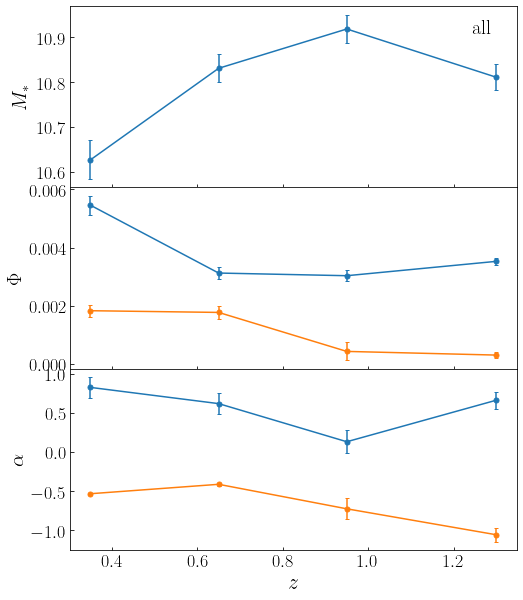

In [494]:
fig, axs = plt.subplots(3, 1, figsize = (8, 10),sharex=True)

sfq='all'
fit_const_sigma = False
if fit_const_sigma:
    fit_params = np.load('fit_param_dsi_'+sfq+'.npy')
    fit_params_err = np.load('fit_param_err_dsi_'+sfq+'.npy')
else:
    fit_params = np.load('fit_param_varysigma_'+sfq+'.npy')
    fit_params_err = np.load('fit_param_err_varysigma_'+sfq+'.npy')
        
phi1_list = []
phi2_list = []
alpha1_list = []
alpha2_list = []
ms_list = []
phi1_err_list = []
phi2_err_list = []
alpha1_err_list = []
alpha2_err_list = []
ms_err_list = []
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]

 # m_s,phi1,alpha_s1,phi2,alpha_s2,sigma_m
for i in range(4): # 4 z-bins
    if fit_params[i][1] > fit_params[i][3]:
        phi1_list.append(fit_params[i][1]/1e3)
        phi2_list.append(fit_params[i][3]/1e3)
        alpha1_list.append(fit_params[i][2])
        alpha2_list.append(fit_params[i][4])
        phi1_err_list.append(fit_params_err[i][1]/1e3)
        phi2_err_list.append(fit_params_err[i][3]/1e3)
        alpha1_err_list.append(fit_params_err[i][2])
        alpha2_err_list.append(fit_params_err[i][4])
    else:
        phi1_list.append(fit_params[i][3]/1e3)
        phi2_list.append(fit_params[i][1]/1e3)
        alpha1_list.append(fit_params[i][4])
        alpha2_list.append(fit_params[i][2])
        phi1_err_list.append(fit_params_err[i][3]/1e3)
        phi2_err_list.append(fit_params_err[i][1]/1e3)
        alpha1_err_list.append(fit_params_err[i][4])
        alpha2_err_list.append(fit_params_err[i][2])

    ms_list.append(fit_params[i][0])
    ms_err_list.append(fit_params_err[i][0])
    
    
axs[0].errorbar((np.array(z_maxs)+np.array(z_mins))/2,ms_list, yerr=ms_err_list, fmt='.-',capsize=2,markersize=10)
axs[1].errorbar((np.array(z_maxs)+np.array(z_mins))/2,phi1_list, yerr=phi1_err_list, fmt='.-',capsize=2,markersize=10)
axs[1].errorbar((np.array(z_maxs)+np.array(z_mins))/2,phi2_list, yerr=phi2_err_list, fmt='.-',capsize=2,markersize=10)
axs[2].errorbar((np.array(z_maxs)+np.array(z_mins))/2,alpha1_list, yerr=alpha1_err_list, fmt='.-',capsize=2,markersize=10)
axs[2].errorbar((np.array(z_maxs)+np.array(z_mins))/2,alpha2_list, yerr=alpha2_err_list, fmt='.-',capsize=2,markersize=10)
axs[0].annotate(sfq,xy=([0.9,0.85]),xycoords='axes fraction',fontsize=20,color='k')

axs[2].set_xlabel(r'$z$',fontsize=22)
axs[0].set_ylabel(r'$M_*$',fontsize=20)
axs[1].set_ylabel(r'$\Phi$',fontsize=20)
axs[2].set_ylabel(r'$\alpha$',fontsize=21)
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)

Text(0, 0.5, '$\\log\\rho (M_\\odot/Mpc^{-3})$')

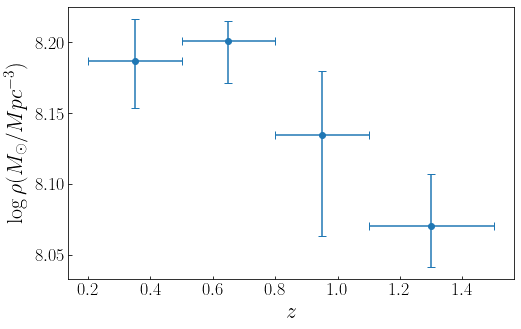

In [503]:
# mass density evolution plot
z_mins = np.array([0.2, 0.5, 0.8, 1.1])
z_maxs = np.array([0.5, 0.8, 1.1, 1.5])
mass_comp_80 = [8.2, 8.5, 9.1, 10]
mass_comp_sf_80 = [8.2, 8.5, 9.1, 10.]
mass_comp_q_80 = [8.5, 9.1, 9.9, 10.6]

sfq='all'
fit_const_sigma = False
if fit_const_sigma:
    fit_params = np.load('fit_param_dsi_'+sfq+'.npy')
    fit_params_err = np.load('fit_param_err_dsi_'+sfq+'.npy')
else:
    fit_params = np.load('fit_param_varysigma_'+sfq+'.npy')
    fit_params_err = np.load('fit_param_err_varysigma_'+sfq+'.npy')

cat_comp = Table.read('comp_sigmoid_params.fits')

rho_star = []
rho_star_16 = []
rho_star_84 = []
m_lower = 8
m_higher = 12.5
step = 0.01
for i in range(4): # 4 z-bins
    ms = fit_params[i][0]
    phi1 = fit_params[i][1]/1e3
    phi2 = fit_params[i][3]/1e3
    alpha1 = fit_params[i][2]
    alpha2 = fit_params[i][4]
    
    alpha1_lowz = fit_params[0][2]
    alpha2_lowz = fit_params[0][4]
    
    if sfq =='sf':
        m_limit = mass_comp_sf_80[i]
    elif sfq == 'q':
        m_limit = mass_comp_q_80[i]
    else:
        m_limit = mass_comp_80[i]
    
    # mass density
    total_mass = 0
    factor = double_schechter(m_limit, ms,phi1,alpha1,phi2,alpha2)*step*10**(m_limit-8) / double_schechter(m_limit, ms,phi1,alpha1_lowz,phi2,alpha2_lowz)*step*10**(m_limit-8) # normalization factor to use a general alpha at low mass
    for m in np.arange(m_lower,m_higher,step):
        if m > m_limit:
            total_mass += double_schechter(m, ms,phi1,alpha1,phi2,alpha2)*step*10**(m-8)
        else:
            total_mass += double_schechter(m, ms,phi1,alpha1_lowz,phi2,alpha2_lowz)*step*10**(m-8) * factor
    rho_star.append(np.log10(total_mass)+8)
    
    # calculate uncertainty
    total_mass_js = []
    for j in range(50):
        popt_j = fit_params[i] + (np.random.rand(6)-0.5)*2*fit_params_err[i]
        ms_j = popt_j[0]
        phi1_j = popt_j[1]/1e3
        phi2_j = popt_j[3]/1e3
        alpha1_j = popt_j[2]
        alpha2_j = popt_j[4]
        
        total_mass_j = 0
        for m in np.arange(m_lower,m_higher,step):
            if m > m_limit:
                total_mass_j += double_schechter(m, ms_j,phi1_j,alpha1_j,phi2_j,alpha2_j)*step*10**(m-8)
            else:
                total_mass_j += double_schechter(m, ms_j,phi1_j,alpha1_lowz,phi2_j,alpha2_lowz)*step*10**(m-8) * factor
                
        total_mass_js.append(total_mass_j)
        
    rho_star_16.append(np.log10(np.percentile(total_mass_js,16))+8)
    rho_star_84.append(np.log10(np.percentile(total_mass_js,84))+8)

rho_star = np.array(rho_star)
rho_star_16 = np.array(rho_star_16)
rho_star_84 = np.array(rho_star_84)

fig, axs = plt.subplots(1, 1, figsize = (8, 5),sharex=True)
axs.errorbar((z_mins+z_maxs)/2,rho_star,xerr=(z_maxs-z_mins)/2 ,yerr=(rho_star-rho_star_16, rho_star_84-rho_star),fmt='o',capsize=4)
axs.set_xlabel(r'$z$',fontsize=22)
axs.set_ylabel(r'$\log\rho (M_\odot/Mpc^{-3})$',fontsize=22)

#### schecter function fit

In [14]:
from scipy.optimize import curve_fit
from bisect import bisect

# schecter function
def schechter(log_m,phi,log_m_s,alpha_s):
    m_s = 10**(log_m_s-10)
    m = 10**(log_m-10)
    return phi*(m/m_s)**(alpha_s)*np.exp(-(m/m_s))

def double_schechter(log_m,log_m_s,phi1,alpha_s1,phi2,alpha_s2):
    m_s = 10**(log_m_s-10)
    m = 10**(log_m-10)
    return (phi1*(m/m_s)**(alpha_s1)+phi2*(m/m_s)**(alpha_s2))*np.exp(-(m/m_s))

def con_double_schec_varysigma(masses,m_s,phi1,alpha_s1,phi2,alpha_s2,z_min):
    intervals = 300
    mrange = np.linspace(8, 12.2, intervals)
    dx = (12.2-8)/intervals
    values = double_schechter(mrange+dx/2,m_s,phi1,alpha_s1,phi2,alpha_s2)  # un-convolved values 
    
    z_min = round(z_min,1)
    arr = np.load('mass_err/mass_err_overall_all_'+str(z_min)+'.npy')
    mass_err_x = arr[0]
    mass_err_y = arr[1]

    # calculate convolved values
    if isinstance(masses, list) or isinstance(masses, np.ndarray):
        con_values = []
        for m in masses:
            sigma_m_var = np.interp(m,mass_err_x,mass_err_y)
            kernel = []  # the gaussian kernel
            for i in range(int(-3*sigma_m_var/dx),int(3*sigma_m_var/dx)+1):
                kernel.append(gaussian(i*dx,0,sigma_m_var))
            kernel = np.array(kernel)
            kernel  = kernel / sum(kernel)
            con_values.append(np.convolve(values,kernel,mode='same')[min(bisect(mrange, m),intervals-1)])
    elif isinstance(masses, float):
        m = masses
        sigma_m_var = np.interp(m,mass_err_x,mass_err_y)
        kernel = []
        for i in range(int(-3*sigma_m_var/dx),int(3*sigma_m_var/dx)+1):
            kernel.append(gaussian(i*dx,0,sigma_m_var))
        kernel = np.array(kernel)
        kernel  = kernel / sum(kernel)
        con_values = np.convolve(values, kernel, mode='same')[min(bisect(mrange, m),intervals-1)]  
    else:
        raise ValueError("wrong value for mass...")
    
    return np.array(con_values)
        
def con_double_schechter(masses,m_s,phi1,alpha_s1,phi2,alpha_s2, sigma_m): # convolved schecter function with a gaussian function
    intervals = 300
    mrange = np.linspace(8, 12.2, intervals)
    dx = (12.2-8)/intervals
    values = double_schechter(mrange+dx/2,m_s,phi1,alpha_s1,phi2,alpha_s2)  # un-convolved values 
    
    # the gaussian kernel (same sigma_m for all masses)
    kernel_const = []
    con_values = []
    for i in range(int(-3*sigma_m/dx),int(3*sigma_m/dx)+1):
        kernel_const.append(gaussian(i*dx,0,sigma_m))
    kernel_const = np.array(kernel_const)
    kernel_const  = kernel_const / sum(kernel_const)
    
    # calculate convolved values
    if isinstance(masses, list) or isinstance(masses, np.ndarray):
        for m in masses:
            con_values.append(np.convolve(values,kernel_const,mode='same')[min(bisect(mrange, m),intervals-1)])
    elif isinstance(masses, float):
        con_values = np.convolve(values, kernel_const, mode='same')[min(bisect(mrange, m),intervals-1)]  
    else:
        raise ValueError("wrong value for mass...")
        
    return np.array(con_values)


def con_schechter(masses,phi,m_s,alpha_s,sigma): # convolved schecter function with a gaussian function
    intervals = 300
    dx = (12.2-8)/intervals
    
    # the gaussian kernel
    kernel = []
    for i in range(int(-3*sigma/dx),int(3*sigma/dx)+1):
        kernel.append(gaussian(i*dx,0,sigma))
    kernel = np.array(kernel)
    kernel  = kernel / sum(kernel)
    
    # calculate convolved values
    con_values = []
    mrange = np.linspace(8, 12.2, intervals)
    values = schechter(mrange+dx/2,phi,m_s,alpha_s)   
    if isinstance(masses, list) or isinstance(masses, np.ndarray):
        for m in masses:
            con_values.append(np.convolve(values,kernel,mode='same')[min(bisect(mrange, m),intervals-1)])
    else:
        m = masses 
        con_values = np.convolve(values, kernel, mode='same')[min(bisect(mrange, m),intervals-1)]           
    return np.array(con_values)

def gaussian(x, mu, sig):
    return 1/(sig*np.sqrt(2*np.pi))*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))


In [15]:
# fitting schecter function
def fit_schechter(xdata, ydata, ydata_err, start, end): # phi,m_s,alpha
    popt,pcov = curve_fit(schechter, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=[2e-4,2.2e+04,-1.75])
    res = ydata - schechter(xdata, *popt)
    chi2_ = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2_

def fit_schechter_con(xdata, ydata, ydata_err, start, end, sigma_m): # phi,m_s,alpha,sigma_m
    popt,pcov = curve_fit(con_schechter, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=[2e-4,2.1e+01,-1.5,sigma_m],bounds=([0,1e3,-2,sigma_m-0.00000001],[1e-2,1e5,2,sigma_m]),method='trf',absolute_sigma=True)
    res = ydata - con_schechter(xdata, *popt)
    chi2_ = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2_

def fit_double_schechter(xdata, ydata, ydata_err, start, end): # m_s,phi1,alpha_s1,phi2,alpha_s2
    popt,pcov = curve_fit(double_schechter, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=[11,2e-1,-0.5,2e-1,-1.5],bounds=([10,0,-2,0,-2],[12,1e1,2,1e1,0]))
    res = ydata - double_schechter(xdata, *popt)
    chi2_ = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2_

def fit_double_schechter_con(xdata, ydata, ydata_err, start, end, sigma_m, double_fit=True): # log_m_s,phi1,alpha_s1,phi2,alpha_s2,sigma_m
    if double_fit: # double schechter fit
        p0_fit = [11,2e-1,-0.5,2e-1,-1.5,sigma_m]
        bounds_low_fit = [10,0,-2,0,-2,sigma_m-0.00001]
        bounds_high_fit = [12,1e1,2,1e1,0,sigma_m+0.00001]
    else:  # reduce to single schechter fit
        p0_fit = [11,2e-1,-0.5,0,0,sigma_m]
        bounds_low_fit = [10,0,-2,0,0,sigma_m-0.00001]
        bounds_high_fit = [12,1e1,2,1e-15,1e-10,sigma_m+0.00001]
        
    popt,pcov = curve_fit(con_double_schechter, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=p0_fit,bounds=(bounds_low_fit,bounds_high_fit))
    res = ydata - con_double_schechter(xdata, *popt)
    chi2_ = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2_

def fit_double_schec_varysigma_con(xdata, ydata, ydata_err, start, end, zmin, double_fit=True): # log_m_s,phi1,alpha_s1,phi2,alpha_s2, (z_min, z_max)
    if double_fit: # double schechter fit
        p0_fit = [11,2e-1,-0.5,2e-1,-1.5,zmin]
        bounds_low_fit = [10,0,-2,0,-2,zmin-0.00001]
        bounds_high_fit = [12,1e1,2,1e1,0,zmin+0.00001]
    else:  # reduce to single schechter fit
        p0_fit = [11,2e-1,-0.5,0,0,zmin]
        bounds_low_fit = [10,0,-2,0,0,zmin-0.00001]
        bounds_high_fit = [12,1e1,2,1e-15,1e-10,zmin+0.00001]
        
    popt,pcov = curve_fit(con_double_schec_varysigma, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=p0_fit,bounds=(bounds_low_fit,bounds_high_fit))
    res = ydata - con_double_schec_varysigma(xdata, *popt)
    chi2_ = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2_

#### MCMC fit

In [6]:
# maximum likelihood
import emcee
from scipy.optimize import minimize

def log_prior_convolve(theta):
    phi,m_s,alpha_s,sigma = theta
    if 0 < phi < 1 and 0.0 < m_s < 2e4 and -5.0 < alpha_s < 0.0 and sigma>0:
        return 0.0
    return -np.inf

def log_likelihood_convolve(theta, x, y, yerr):
    phi,m_s,alpha_s,sigma = theta
    model = con_schechter(x, phi, m_s, alpha_s, sigma)
    sigma2 = yerr ** 2 
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_probability_convolve(theta, x, y, yerr):
    lp = log_prior_convolve(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_convolve(theta, x, y, yerr)

###################################################################
# sigma_m is not a free parameter
def log_prior_double_convolve(theta):
    m_s,phi1,alpha_s1,phi2,alpha_s2,sigma_m,z_min,z_max = theta
    if 10 < m_s < 12 and 0 < phi1 < 1 and  -2.0 < alpha_s1 < 1.0 and 0 < phi2 < 1 and  -2.0 < alpha_s2 < 2.0:
        return 0.0
    return -np.inf

def log_likelihood_convolve(theta, x, y, yerr):
    m_s,phi1,alpha_s1,phi2,alpha_s2 = theta
    model = con_double_schechter(x, m_s, phi1, alpha_s1, phi2, alpha_s2, sigma_m,z_min,z_max)
    sigma2 = yerr ** 2 
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_probability_convolve(theta, x, y, yerr):
    lp = log_prior_convolve(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_convolve(theta, x, y, yerr)

#################################################################
def log_prior(theta):
    phi,m_s,alpha_s = theta
    if 0 < phi < 1 and 0.0 < m_s < 2e4 and -5.0 < alpha_s < 0.0:
        return 0.0
    return -np.inf

def log_likelihood(theta, x, y, yerr):
    phi,m_s,alpha_s = theta
    model = schechter(x, phi, m_s, alpha_s)
    sigma2 = yerr ** 2 
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [7]:
def mcmc_fit_convolve(x, y, yerr, start=5, end=-5, chain_length=50000):
    x = x[start:end]
    y = y[start:end]
    yerr = yerr[start:end]
    nll = lambda *args: -log_likelihood_convolve(*args) # Negative Log-Likelihood
    initial = np.array([1e-3,2.2e+04,-0.75, 0.1])
    soln = minimize(nll, initial, args=(x, y, yerr),bounds=[(1e-6,1e-2),(1e3,1e5),(-2,0),(0.02,2)])
    
    pos = soln.x + np.array([0.5e-4,0.5e+04,0.5, 0.2])*np.random.randn(200, 4)
    nwalkers, ndim = pos.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_convolve, args=(x, y, yerr))
    sampler.run_mcmc(pos, chain_length, progress=True)
    params = np.mean(sampler.get_chain(discard=100, thin=15, flat=True),axis=0)
    return sampler,soln.x,params

def mcmc_fit(x, y, yerr,start=5, end=-5, chain_length=50000):
    x = x[start:end]
    y = y[start:end]
    yerr = yerr[start:end]
    
    nll = lambda *args: -log_likelihood(*args) # Negative Log-Likelihood
    initial = np.array([1e-3,2.2e+04,-0.75])
    soln = minimize(nll, initial, args=(x, y, yerr),bounds=[(1e-6,1e-2),(1e3,1e5),(-2,2)])
    phi_ml,m_s_ml,alpha_s_ml = soln.x  # initial guess?
    
    pos = soln.x + 0.2*np.array([1e-4,1e+04,1])*np.random.randn(200, 3)
    nwalkers, ndim = pos.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
    sampler.run_mcmc(pos, chain_length, progress=True)
    params = np.mean(sampler.get_chain(discard=200, thin=15, flat=True),axis=0)
    return sampler,soln.x,params


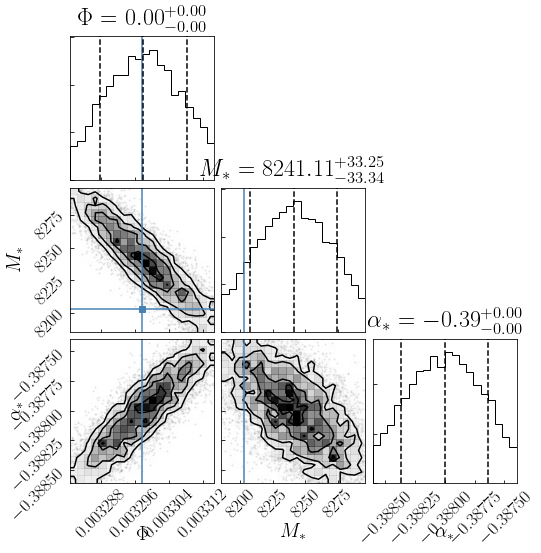

In [466]:
import corner
from matplotlib import rcParams
rcParams["font.size"] = 20
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

labels = [r"$\Phi$", r"$M_*$", r"$\alpha_*$"]
fig = corner.corner(
    flat_samples, labels=labels, truths=params,show_titles=True,quantiles=[.16,.50,.84],range=[0.90,0.90,0.90] 
);


#### MCMC with Thibaud's data

In [270]:
# maximum likelihood
import emcee
from scipy.optimize import minimize

# data
x = data_sf1[:,0]
y = 10**data_sf1[:,1]
yerr = 10**data_sf1[:,1]/50

params = mcmc_fit(x,y,yerr,chain_length=1000)
print(params)

/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in square
  from ipykernel import kernelapp as app
/Users/lejay/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in square
  from ipykernel import kernelapp as app
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in true_divide
  from ipykernel import kernelapp as app
  0%|          | 0/1000 [00:00<?, ?it/

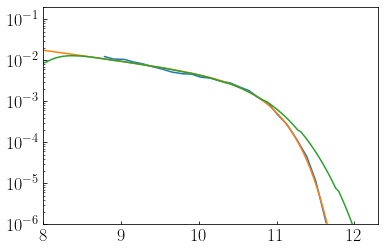

In [ ]:
x_plot = np.linspace(8,12,100)
plt.plot(x,y)
plt.plot(x_plot, schechter(x_plot),params[0],params[1],params[2])
plt.plot(x_plot, con_schechter(x_plot,params[0],params[1],params[2],0.25))
plt.xlim([8,12.3])
plt.ylim([1e-6,2e-1])
plt.yscale('log')

#### fitting with literature data

In [954]:
def double_schechter2(log_m,log_m_s,phi1,alpha_s1,phi2,alpha_s2):
    m_s = 10**(log_m_s-10)
    m = 10**(log_m-10)
    return np.log(10)*( phi1*(m/m_s)**(alpha_s1+1) + phi2*(m/m_s)**(alpha_s2+1) )*np.exp(-(m/m_s))

def fit_double_schechter2(xdata, ydata, ydata_err, start, end): # m_s,phi1,alpha_s1,phi2,alpha_s2
    popt,pcov = curve_fit(double_schechter2, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=[10.8,2e-3,-1,2e-4,-2],bounds=([10,0,-3,0,-3],[12,1e1,2,1e1,1]))
    res = ydata - double_schechter2(xdata, *popt)
    chi2_ = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2_

[ 1.100e+01  1.311e-03 -1.028e+00  4.545e-04 -1.467e+00]
[ 1.107e+01  1.711e-03 -1.172e+00  6.767e-06 -2.132e+00]
[ 1.097e+01  1.527e-03 -1.231e+00  4.330e-07 -2.602e+00]


Text(0.5, 1.0, 'Moutard et al., 2016')

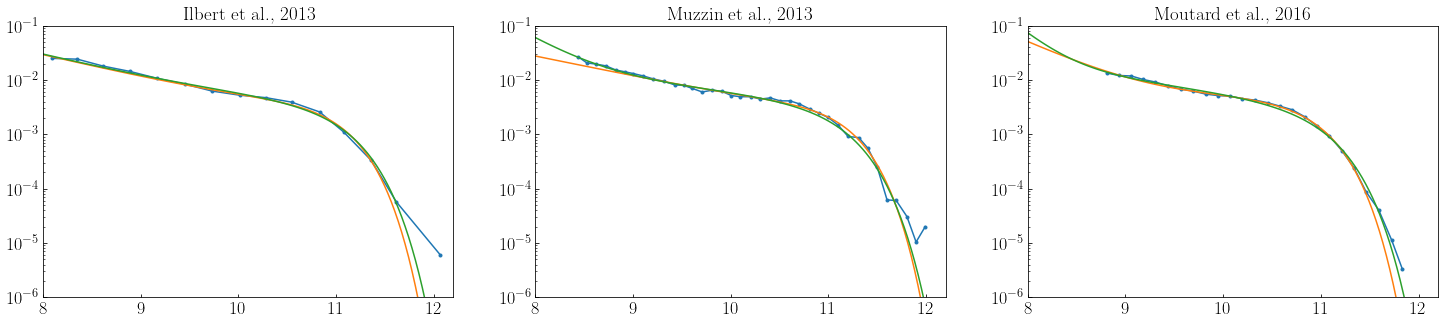

In [955]:
# double schechter, 0.2<z<0.5
fig, axs = plt.subplots(1, 3, figsize = (25, 5),sharex=True)
x_plot = np.linspace(8,12.2,120)

# double_schechter2(log_m,log_m_s,phi1,alpha_s1,phi2,alpha_s2)
# ilbert+2013 
smf_il =  np.load('smf_il_0.2_0.5.npy')
axs[0].plot(smf_il[:,0],10**smf_il[:,1],'.-')
axs[0].plot(x_plot,double_schechter2(x_plot, 10.88, 1.68e-3,-0.69,0.77e-3,-1.42))
popt,pcov,chi2_ = fit_double_schechter2(smf_il[:,0],10**smf_il[:,1],10**smf_il[:,1]/100,1,-1)
axs[0].plot(x_plot,double_schechter2(x_plot, popt[0], popt[1],popt[2],popt[3],popt[4]))
print(popt)
axs[0].set_yscale('log')
axs[0].set_xlim([8,12.2])
axs[0].set_ylim([1e-6,1e-1])
axs[0].set_ylim([1e-6,1e-1])
axs[0].set_title('Ilbert et al., 2013',fontsize=19)

# muzzin+2013 
smf_mu =  np.load('smf_mu_0.2_0.5.npy')
axs[1].plot(smf_mu[:,0],10**smf_mu[:,1],'.-')
axs[1].plot(x_plot,double_schechter2(x_plot, 10.97, 1.627e-3,-0.53,9.47e-4,-1.37))
popt,pcov,chi2_ = fit_double_schechter2(smf_mu[:,0],10**smf_mu[:,1],10**smf_mu[:,1]/100,1,-1)
print(popt)
axs[1].plot(x_plot,double_schechter2(x_plot, popt[0], popt[1],popt[2],popt[3],popt[4]))
axs[1].set_yscale('log')
axs[1].set_xlim([8,12.2])
axs[1].set_ylim([1e-6,1e-1])
axs[1].set_title('Muzzin et al., 2013',fontsize=19)

# moutard+2016
smf_tm = data_all1
axs[2].plot(smf_tm[:,0],10**smf_tm[:,1],'.-')
axs[2].plot(x_plot,double_schechter2(x_plot, 10.83, 10**(-2.63),-0.95,10**(-4.01),-1.82))
popt,pcov,chi2_ = fit_double_schechter2(smf_tm[:,0],10**smf_tm[:,1],10**smf_tm[:,1]/100,1,-1)
print(popt)
axs[2].plot(x_plot,double_schechter2(x_plot, popt[0], popt[1],popt[2],popt[3],popt[4]))
axs[2].set_yscale('log')
axs[2].set_xlim([8,12.2])
axs[2].set_ylim([1e-6,1e-1])
axs[2].set_title('Moutard et al., 2016',fontsize=19)

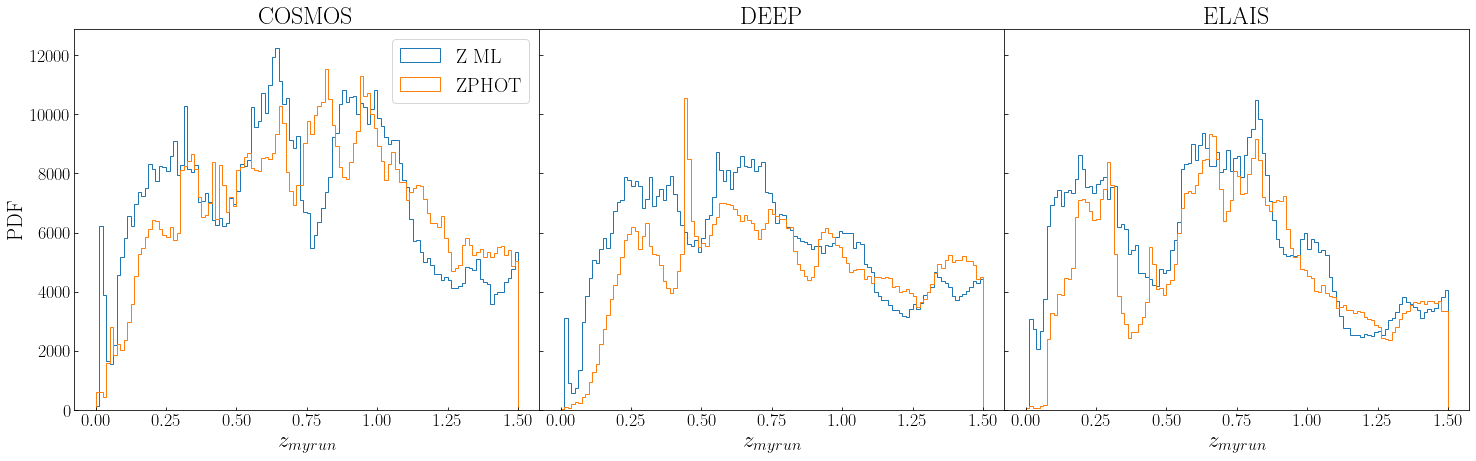

In [1154]:
fig, axs = plt.subplots(1, 3, figsize = (25, 7),sharex=True,sharey=True)

for i, cat_name in enumerate(['COSMOS_deep','DEEP_deep','ELAIS_deep']):
    cat = Table.read(graham_output_dir+cat_name+'_cat_out_nonir_il_22.4_formass.fits')
    cat = cat[cat['Z_ML']<25]
    axs[i].hist(cat['Z_ML'],range=(0.0,1.5),bins=120,histtype='step',label='Z ML')
    axs[i].hist(cat['ZPHOT'],range=(0.0,1.5),bins=120,histtype='step',label='ZPHOT')
    axs[i].set_xlabel('$z_{myrun}$',fontsize=23)
    axs[i].set_title(cat_name.replace('_deep',''))

axs[0].set_ylabel('PDF',fontsize=21)
axs[0].legend(fontsize=20)  
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)

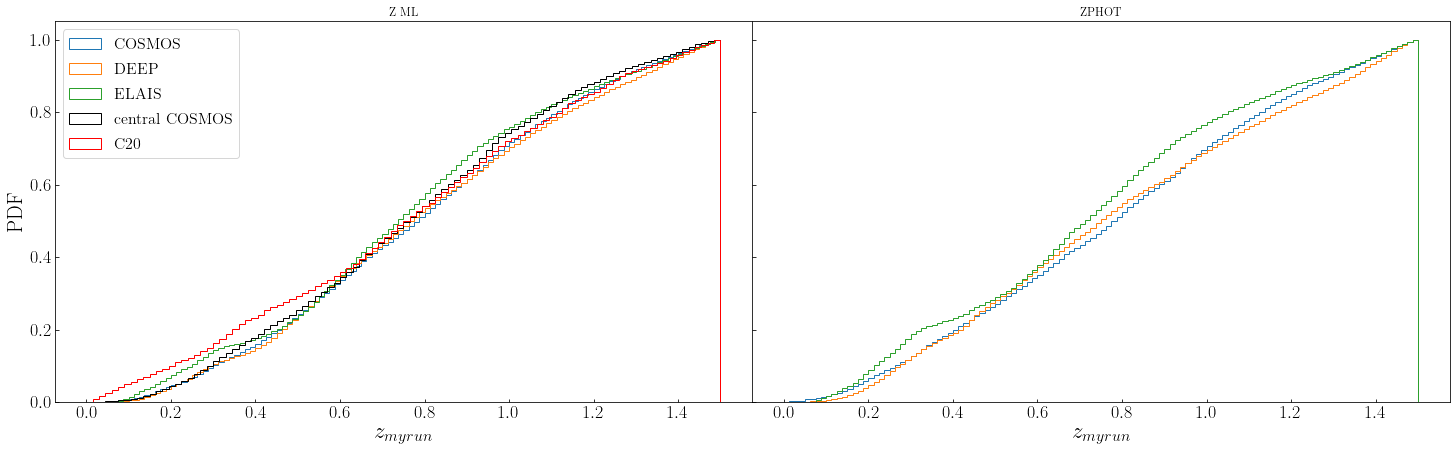

In [17]:
fig, axs = plt.subplots(1, 2, figsize = (25, 7),sharex=True,sharey=True)

for i, ztype in enumerate(['Z_ML','ZPHOT']):
    for cat_name in ['COSMOS_deep','DEEP_deep','ELAIS_deep']:
        cat = Table.read(graham_output_dir+cat_name+'_cat_out_nomaglimit_nonir_il_nz_prior_formass.fits')
        cat = cat[cat[ztype]<26]
        axs[i].hist(cat[ztype],range=(0.0,1.5),bins=120,histtype='step',cumulative=True,density=True,label=cat_name.replace('_deep',''))
    axs[i].set_xlabel('$z_{myrun}$',fontsize=23)
    axs[i].set_title(ztype.replace('_',' '))

cat_central_cosmos = Table.read(graham_output_dir+'cat_out_08squdeg_nonir_il_nz_prior_nolimit_formassc20added.fits')
axs[0].hist(cat_central_cosmos['Z_ML'],range=(0.0,1.5),bins=100,histtype='step',color='k',cumulative=True,density=True,label='central COSMOS')
axs[0].hist(cat_central_cosmos['lp_zPDF'],range=(0.0,1.5),bins=100,histtype='step',color='r',cumulative=True,density=True,label='C20')

axs[0].set_ylabel('PDF',fontsize=21)
axs[0].legend(fontsize=16,loc='upper left')  
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)


In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (25, 7),sharex=True,sharey=True)

for i, ztype in enumerate(['Z_ML','ZPHOT']):
    for cat_name in ['COSMOS_deep','DEEP_deep','ELAIS_deep']:
        cat = Table.read(graham_output_dir+cat_name+'_cat_out_nomaglimit_nonir_il_nz_prior_formass.fits')
        cat = cat[cat[ztype]<26]
        axs[i].hist(cat[ztype],range=(0.0,1.5),bins=120,histtype='step',label=cat_name.replace('_deep',''))
    axs[i].set_xlabel('$z_{myrun}$',fontsize=23)
    axs[i].set_title(ztype.replace('_',' '))

cat_central_cosmos = Table.read(graham_output_dir+'cat_out_08squdeg_nonir_il_nz_prior_nolimit_formassc20added.fits')
axs[0].hist(cat_central_cosmos['Z_ML'],range=(0.0,1.5),bins=100,histtype='step',color='k',label='central COSMOS',weights=np.ones(len(cat_central_cosmos))*8)
axs[0].hist(cat_central_cosmos['lp_zPDF'],range=(0.0,1.5),bins=100,histtype='step',color='r',label='C20',weights=np.ones(len(cat_central_cosmos))*8)

axs[0].set_ylabel('PDF',fontsize=21)
axs[0].legend(fontsize=16)  
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)